# Connection and Credentials

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import sys
sys.path.insert(0, 'drive/Graduation Project/Colaboratory')

# Libraries and Testing GPU

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2295453052719533975, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11287966516
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3146292636560376579
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Data Reading, Cleansing, Preprocessing

In [0]:
df = pd.read_csv('drive/Graduation Project/Colaboratory/user_data_anonymized.csv')
df = df.drop([df.columns[0]],axis=1)

In [0]:
cols = ['sensor_type','trial','name','type','set']
SEQ_LENGTH = 303
OVERLAP = 0
for i in range(SEQ_LENGTH):
    cols.append('x'+str(i))
moving_window_x = pd.DataFrame(columns = cols)

label = pd.DataFrame(columns = ['sensor_type','set','type1','type2','type3','type4'])
s_index = 0
for trial in np.sort(df['ntrial'].unique()):
    nt = df.loc[df['ntrial'] == trial]

    names = df['username'].unique()
    for name in names:
        n = nt.loc[nt['username'] == name]
        
        types = np.array([1,2,3,4])
        for type_ in types:
            t = n.loc[n['type'] == type_]
            
            sensors = t.columns[2:8]
            for sensor in sensors:  
                s = t
                
                if trial == 5: text="test"
                else: text="train"
                    
                row = np.array([sensor])
                row = np.append(row,[trial])
                row = np.append(row,[name])
                row = np.append(row,[type_])
                row = np.append(row,[text])
                if s[sensor].values.shape[0] > SEQ_LENGTH:
                    row = np.append(row,s[sensor].values[:SEQ_LENGTH].astype(float))
                    #print(s[sensor].values[:SEQ_LENGTH])
                elif s[sensor].values.shape[0] <= SEQ_LENGTH:
                    padded_row = np.append(s[sensor].values[:].astype(float),np.array([s[sensor].values[-1].astype(float) for i in range(SEQ_LENGTH-s[sensor].values.shape[0])]))
                    row = np.append(row,padded_row)
                moving_window_x = moving_window_x.append(pd.DataFrame([row],columns=moving_window_x.columns))
                
                row_label = np.array([sensor])
                row_label = np.append(row_label,[text])
                row_label = np.append(row_label,np.zeros((types.shape[0],)))
                row_label[type_+1] = 1.0
                label = label.append(pd.DataFrame([row_label],columns=label.columns))
                
    s_index += s[sensor].shape[0]

In [0]:
moving_window_x['index'] = [i for i in range(moving_window_x.shape[0])]
moving_window_x = moving_window_x.set_index(['index'])

label['index'] = [i for i in range(label.shape[0])]
label = label.set_index(['index'])

In [0]:
train_len = int(moving_window_x.loc[moving_window_x['set'] == 'train'].shape[0]/6)
test_len = int(moving_window_x.loc[moving_window_x['set'] == 'test'].shape[0]/6)

In [0]:
x_train = np.zeros((train_len,SEQ_LENGTH,6))
y_train = np.zeros((train_len,4))

x_test = np.zeros((test_len,SEQ_LENGTH,6))
y_test = np.zeros((test_len,4))

In [0]:
shuffle_data = np.zeros((train_len+test_len,SEQ_LENGTH,6+4))

In [14]:
for i,sensor in enumerate(moving_window_x['sensor_type'].unique()):
    s_train = moving_window_x.loc[moving_window_x['sensor_type'] == sensor]
    s_train = s_train.loc[s_train['set'] == "train"]
    s_test = moving_window_x.loc[moving_window_x['sensor_type'] == sensor]
    s_test = s_test.loc[s_test['set'] == "test"]

    x_train[:,:,i] = s_train.drop(['sensor_type','trial','name','type','set'],axis=1)
    x_test[:,:,i] = s_test.drop(['sensor_type','trial','name','type','set'],axis=1)
    if i == 0:
        l = label.loc[label['sensor_type'] == sensor]
        l_train = l.loc[l['set'] == "train"]
        l_test = l.loc[l['set'] == "test"]
        
        y_train[:,:] = l_train.drop(['sensor_type','set'],axis=1)
        y_test[:,:] = l_test.drop(['sensor_type','set'],axis=1)

print("x_train.shape: "+str(x_train.shape))
print("y_train.shape: "+str(y_train.shape))
print("x_test.shape: "+str(x_test.shape))
print("y_test.shape: "+str(y_test.shape))

x_train.shape: (32, 303, 6)
y_train.shape: (32, 4)
x_test.shape: (8, 303, 6)
y_test.shape: (8, 4)


# Import Keras Library

In [0]:
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, Conv1D
from keras.callbacks import History
from keras.optimizers import Adam
import seaborn as sn
import time

In [37]:
  batch_size = 8
  timesteps = SEQ_LENGTH
  data_dim = 6


  model1 = Sequential()
  model1.add(Conv1D(filters=6,kernel_size=9,strides=2,batch_input_shape=(batch_size,timesteps,data_dim)))
  model1.add(CuDNNLSTM(36, return_sequences=True))
  model1.add(CuDNNLSTM(24))
  model1.add(Dense(12,activation='tanh'))
  model1.add(Dense(4, activation='softmax'))

  model1.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])
  model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (8, 148, 6)               330       
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (8, 148, 36)              6336      
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (8, 24)                   5952      
_________________________________________________________________
dense_1 (Dense)              (8, 12)                   300       
_________________________________________________________________
dense_2 (Dense)              (8, 4)                    52        
Total params: 12,970
Trainable params: 12,970
Non-trainable params: 0
_________________________________________________________________


In [38]:
  model2 = Sequential()
  model2.add(Conv1D(filters=6,kernel_size=15,strides=3,batch_input_shape=(batch_size,timesteps,data_dim)))
  model2.add(CuDNNLSTM(36, return_sequences=True))
  model2.add(CuDNNLSTM(24))
  model2.add(Dense(12,activation='tanh'))
  model2.add(Dense(4, activation='softmax'))

  model2.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])
  model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (8, 97, 6)                546       
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (8, 97, 36)               6336      
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (8, 24)                   5952      
_________________________________________________________________
dense_3 (Dense)              (8, 12)                   300       
_________________________________________________________________
dense_4 (Dense)              (8, 4)                    52        
Total params: 13,186
Trainable params: 13,186
Non-trainable params: 0
_________________________________________________________________


In [39]:
  model3 = Sequential()
  model3.add(Conv1D(filters=6,kernel_size=21,strides=6,batch_input_shape=(batch_size,timesteps,data_dim)))
  model3.add(CuDNNLSTM(36, return_sequences=True))
  model3.add(CuDNNLSTM(24))
  model3.add(Dense(12,activation='tanh'))
  model3.add(Dense(4, activation='softmax'))

  model3.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])
  model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (8, 48, 6)                762       
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (8, 48, 36)               6336      
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (8, 24)                   5952      
_________________________________________________________________
dense_5 (Dense)              (8, 12)                   300       
_________________________________________________________________
dense_6 (Dense)              (8, 4)                    52        
Total params: 13,402
Trainable params: 13,402
Non-trainable params: 0
_________________________________________________________________


In [49]:
  model4 = Sequential()
  model4.add(Conv1D(filters=6,kernel_size=30,strides=8,batch_input_shape=(batch_size,timesteps,data_dim)))
  model4.add(CuDNNLSTM(36, return_sequences=True))
  model4.add(CuDNNLSTM(24))
  model4.add(Dense(12,activation='tanh'))
  model4.add(Dense(4, activation='softmax'))

  model4.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])
  model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_59 (Conv1D)           (8, 35, 6)                1086      
_________________________________________________________________
cu_dnnlstm_77 (CuDNNLSTM)    (8, 35, 36)               6336      
_________________________________________________________________
cu_dnnlstm_78 (CuDNNLSTM)    (8, 24)                   5952      
_________________________________________________________________
dense_77 (Dense)             (8, 12)                   300       
_________________________________________________________________
dense_78 (Dense)             (8, 4)                    52        
Total params: 13,726
Trainable params: 13,726
Non-trainable params: 0
_________________________________________________________________


# 1 Convolution layer changes input seq (303->148)

experiment 1 begins

60 secs for training


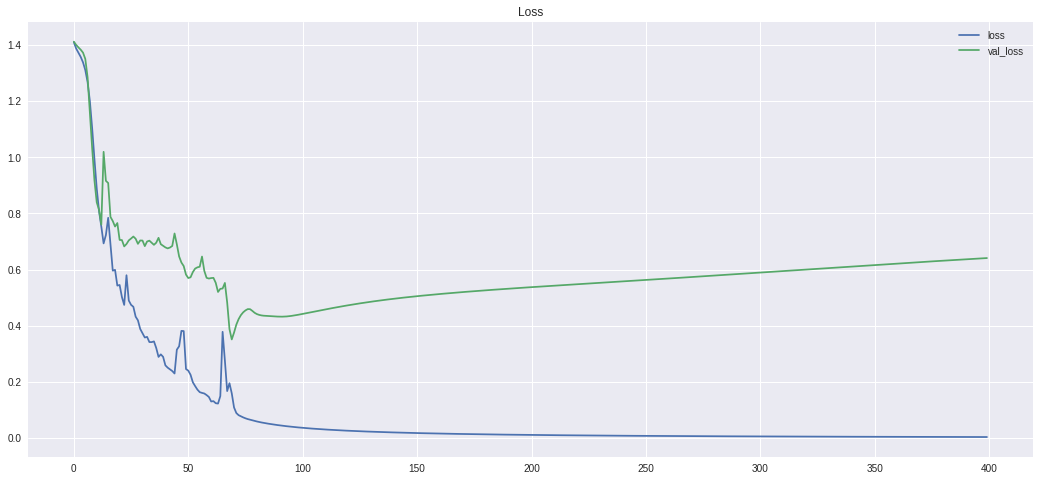

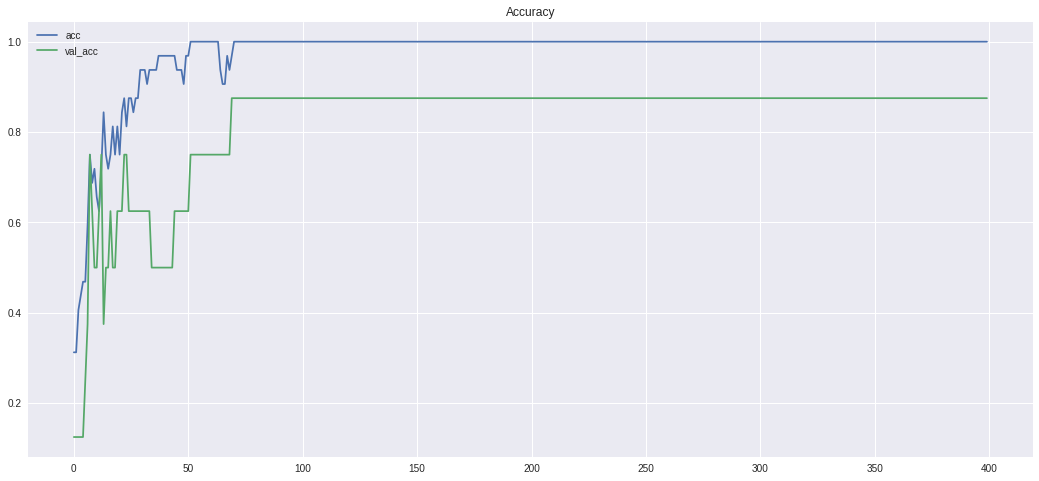

experiment 2 begins

61 secs for training


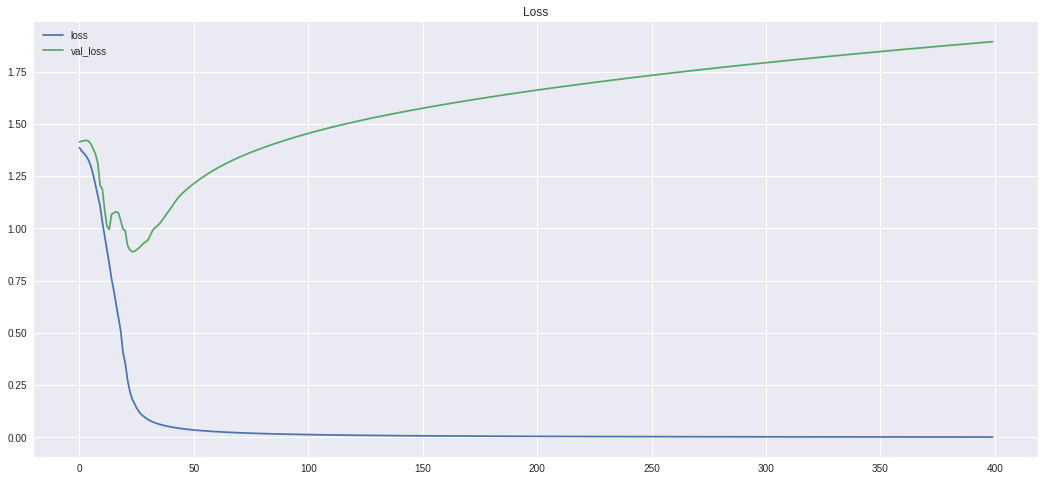

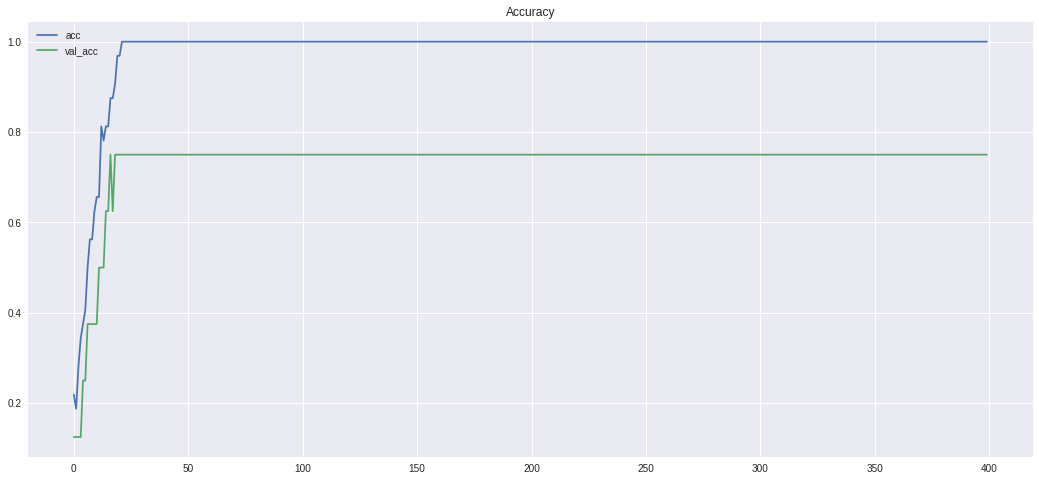

experiment 3 begins

61 secs for training


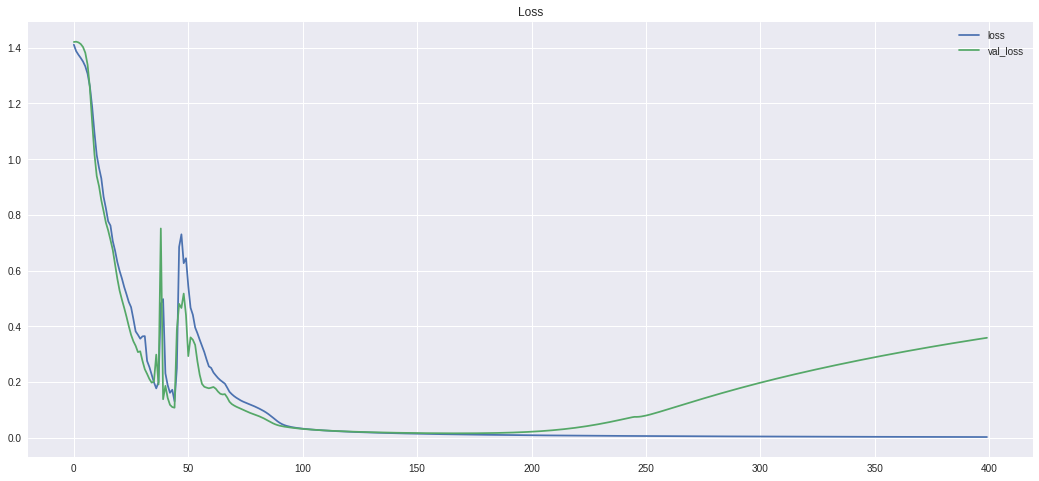

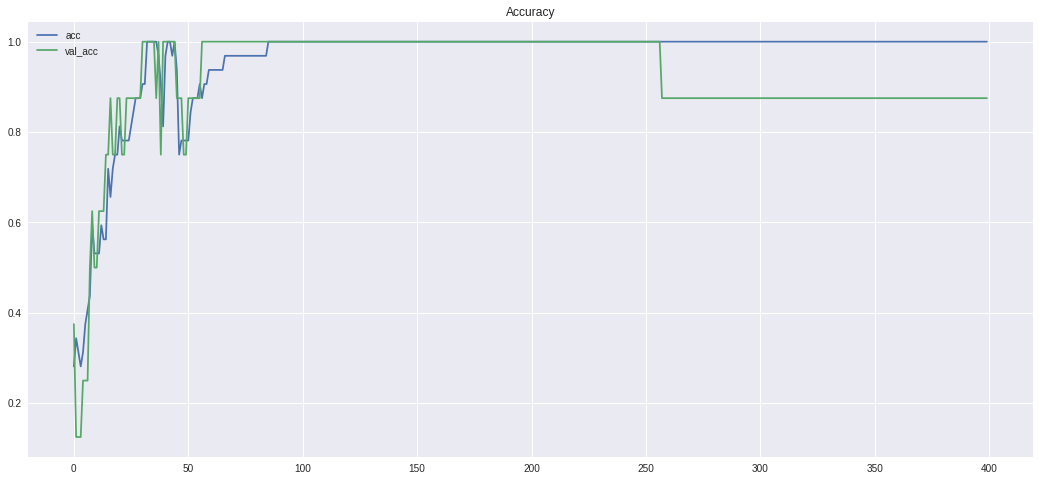

experiment 4 begins

61 secs for training


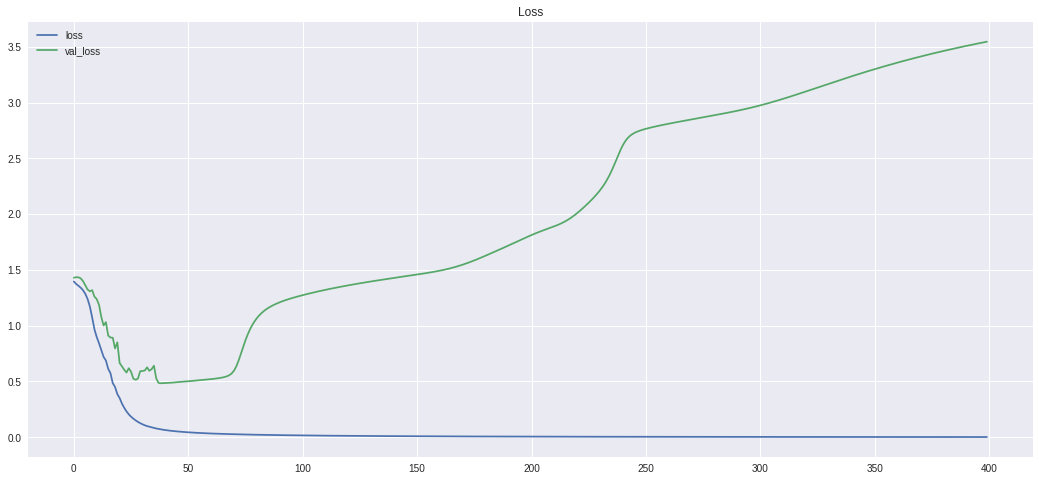

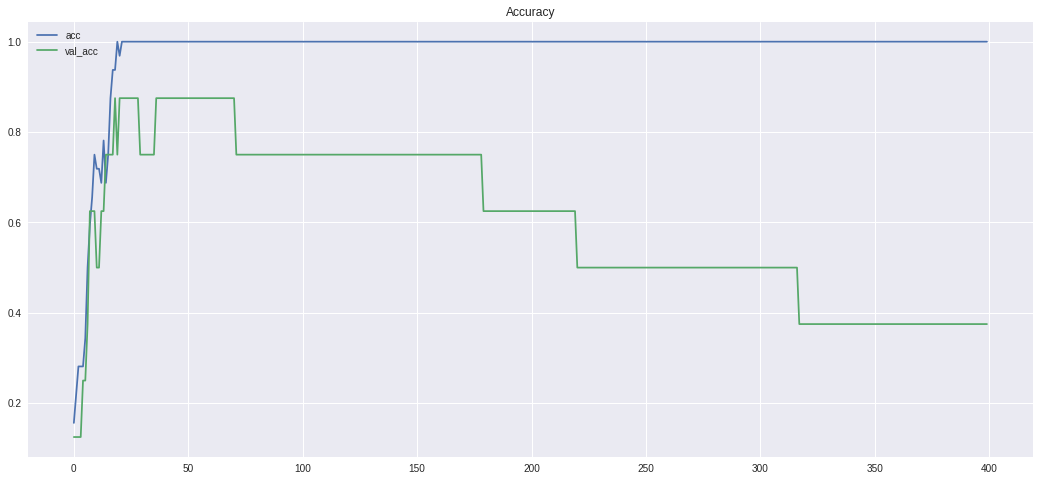

experiment 5 begins

61 secs for training


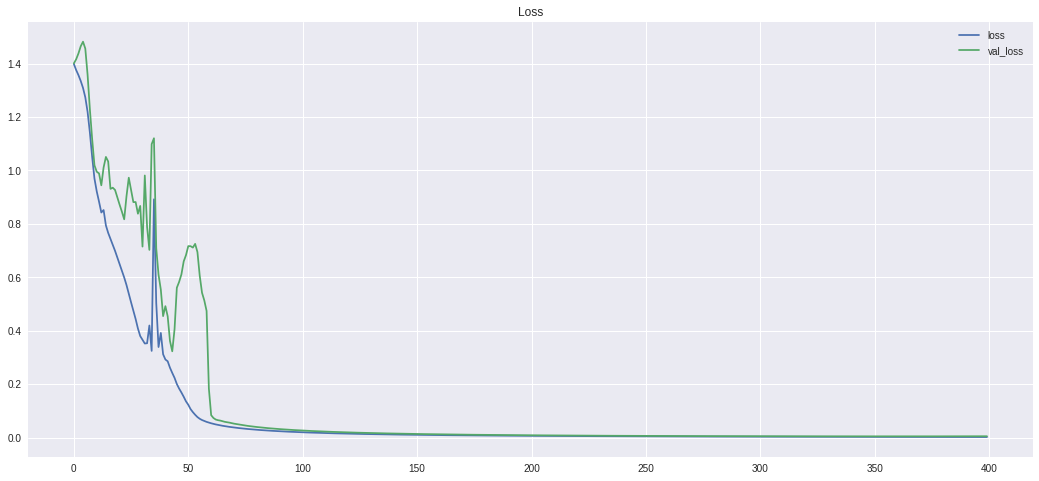

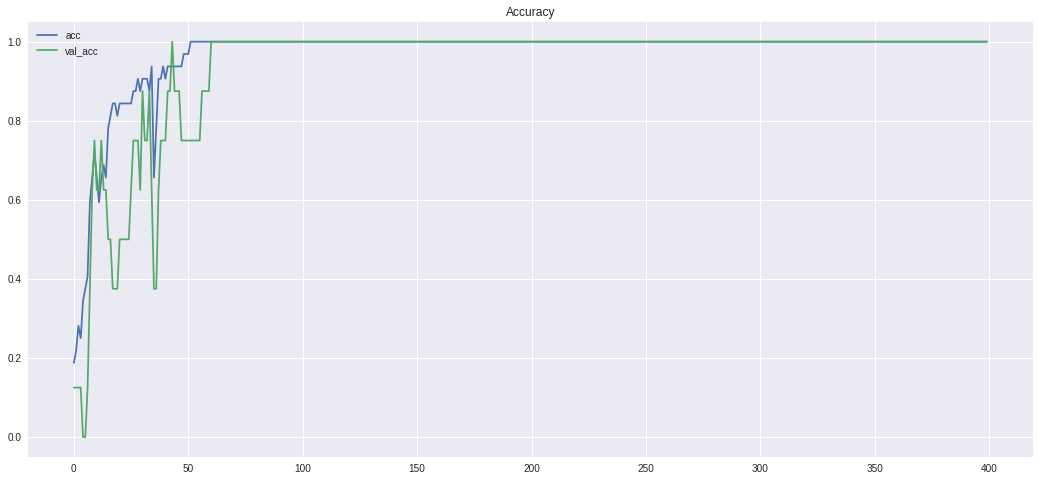

experiment 6 begins

61 secs for training


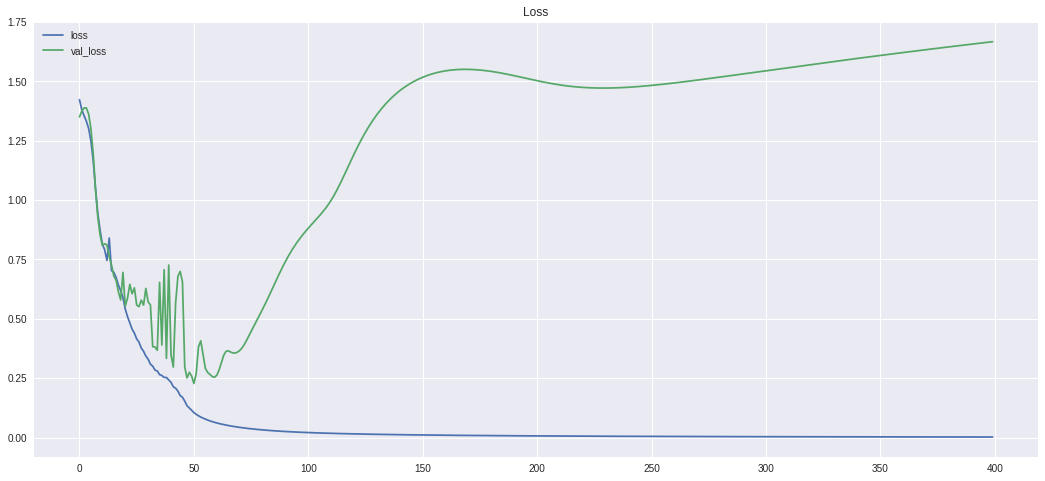

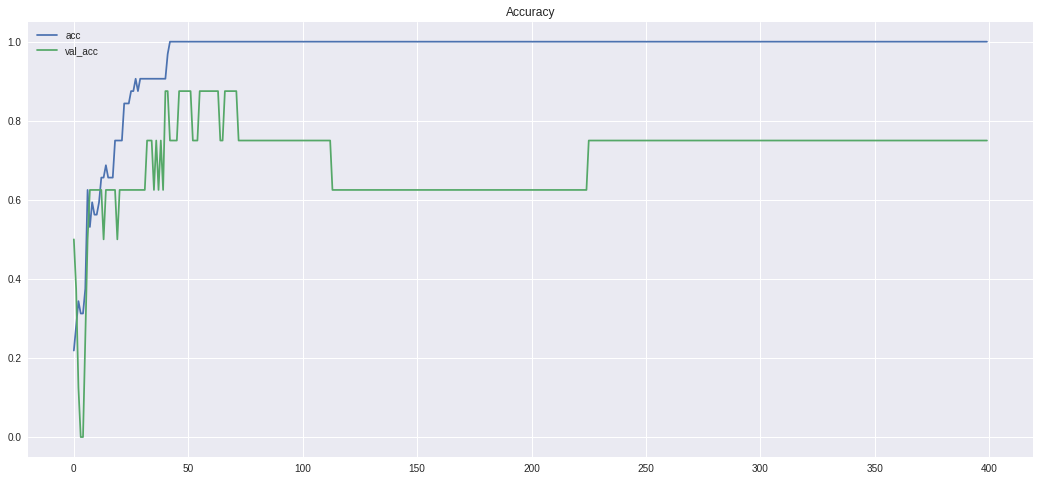

experiment 7 begins

62 secs for training


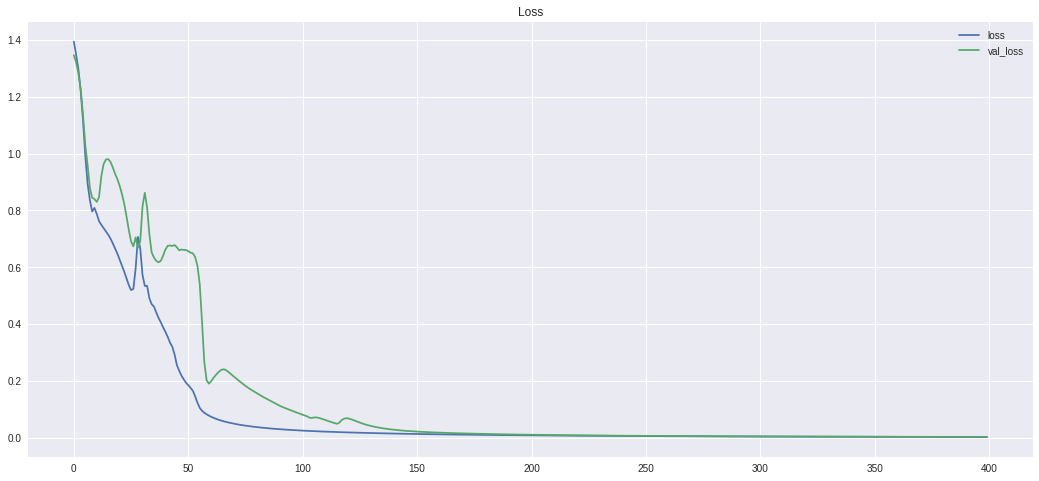

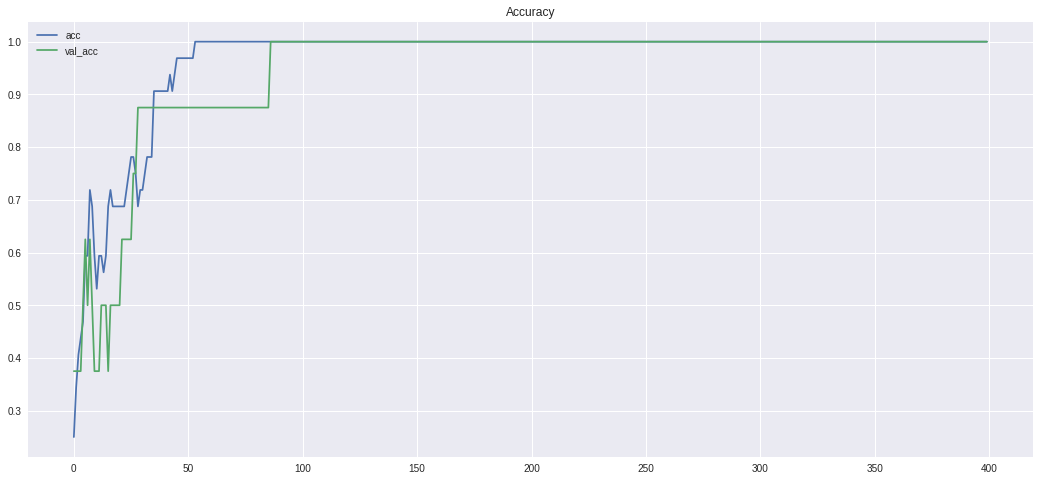

experiment 8 begins

62 secs for training


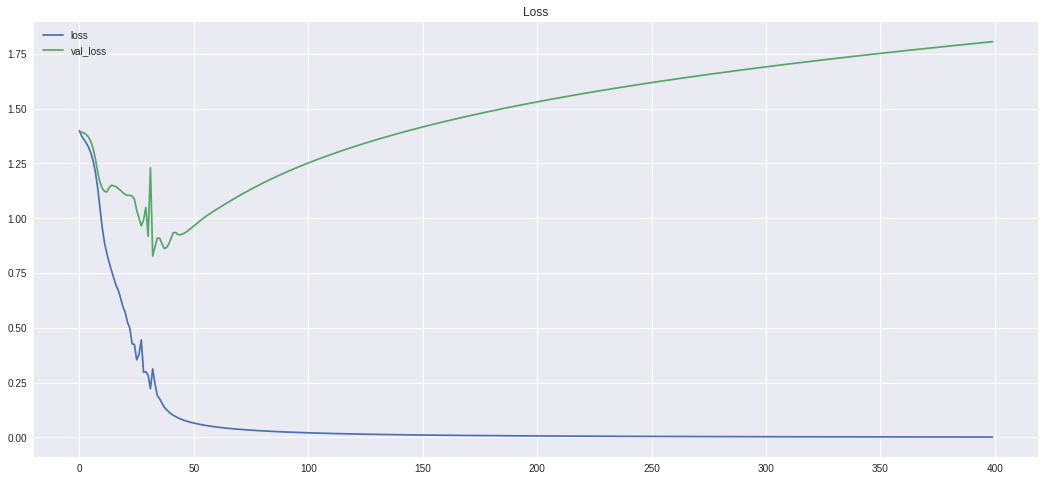

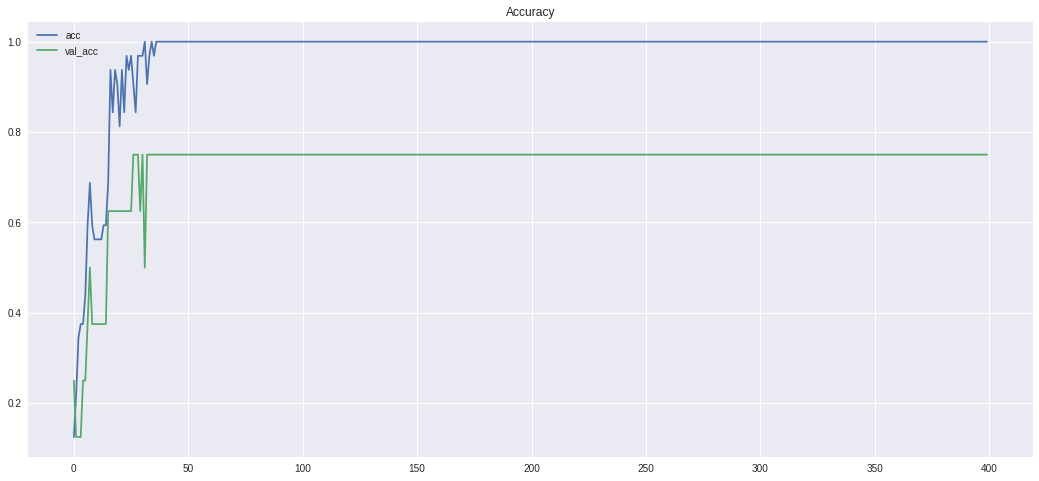

experiment 9 begins

61 secs for training


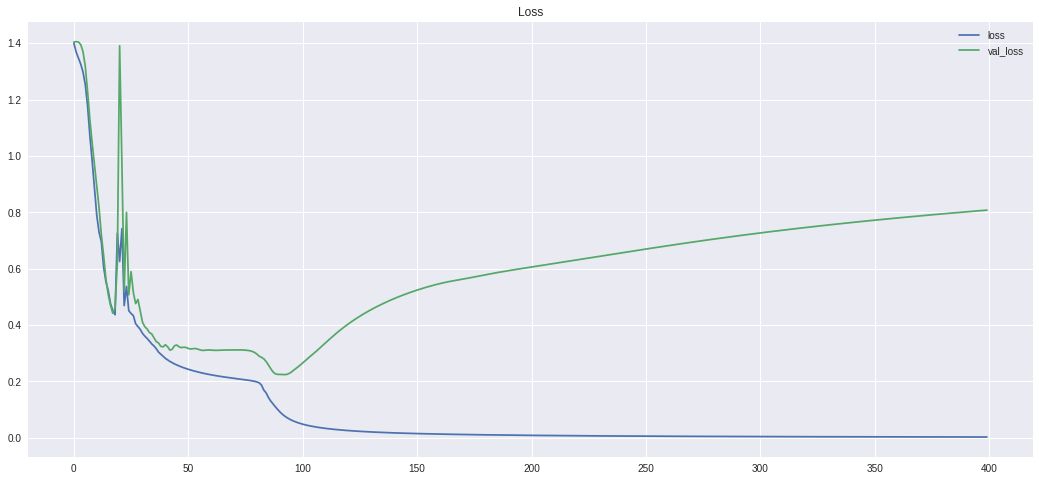

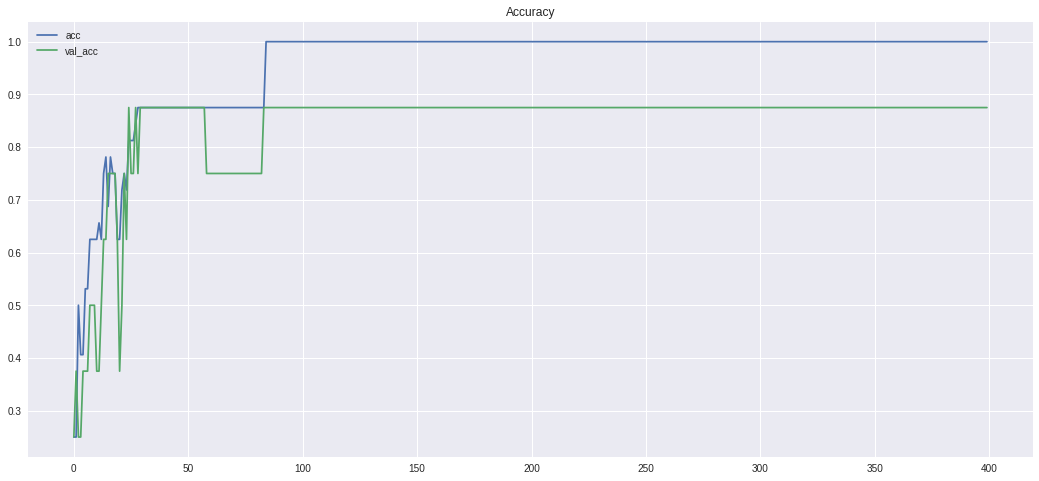

experiment 10 begins

62 secs for training


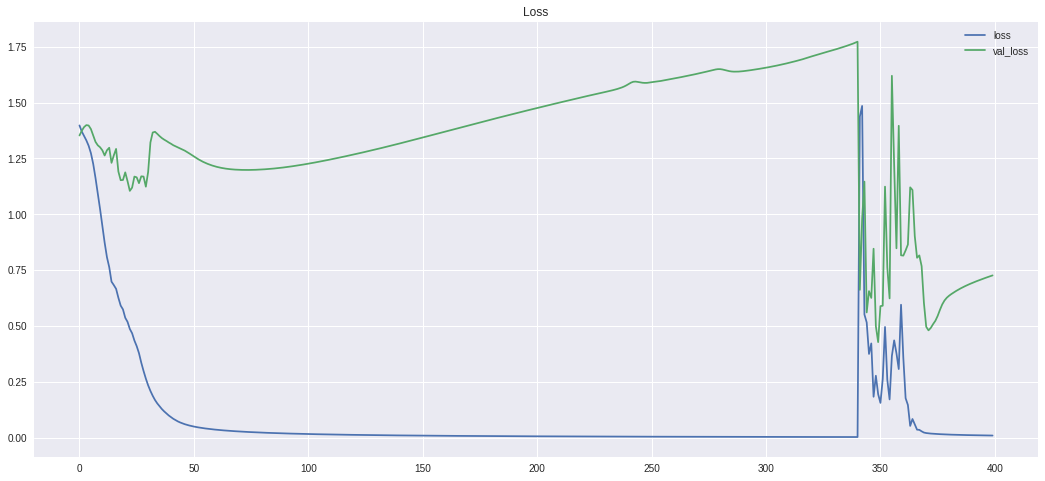

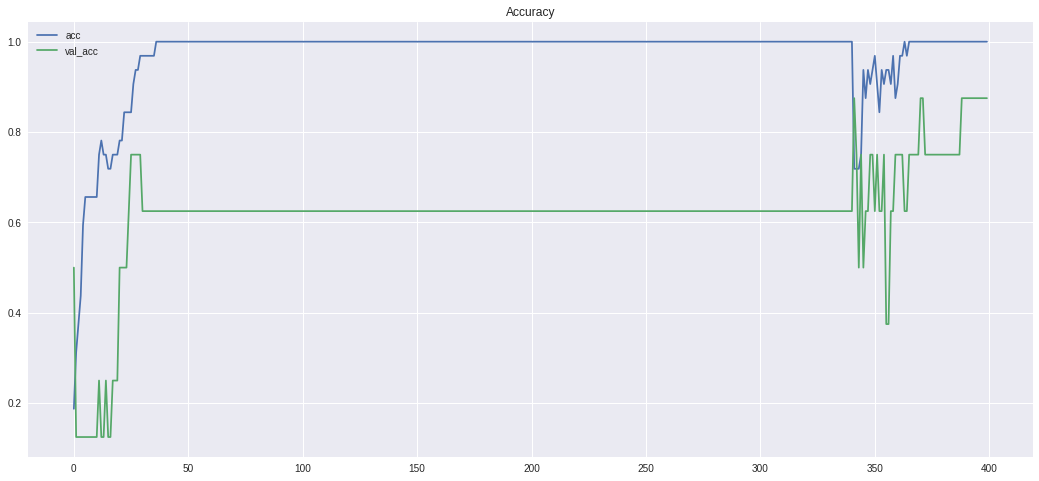

   acc_train  acc_test
0        1.0     0.875
0        1.0     0.750
0        1.0     0.875
0        1.0     0.375
0        1.0     1.000
0        1.0     0.750
0        1.0     1.000
0        1.0     0.750
0        1.0     0.875
0        1.0     0.875


In [42]:
acc = pd.DataFrame(columns=['acc_train','acc_test'])
for e in range(1,11):
  print("experiment %d begins\n"%e)
  y_train_ = np.zeros((32,303,4))
  y_train_[:,0,:] = y_train

  y_test_ = np.zeros((8,303,4))
  y_test_[:,0,:] = y_test

  shuffle_data[:32,:,:6] = x_train
  shuffle_data[:32,:,6:] = y_train_

  shuffle_data[32:,:,:6] = x_test
  shuffle_data[32:,:,6:] = y_test_


  while True:
    np.random.shuffle(shuffle_data)

    x_train = shuffle_data[:32,:,:6]
    x_test = shuffle_data[32:,:,:6]
    y_train = shuffle_data[:32,0,6:].reshape(32,4)
    y_test = shuffle_data[32:,0,6:].reshape(8,4)
    if np.sum(y_test[:,0]) == 2:
        if np.sum(y_test[:,1]) == 2:
            if np.sum(y_test[:,2]) == 2:
                if np.sum(y_test[:,3]) == 2:
                    break

  model1 = Sequential()
  model1.add(Conv1D(filters=6,kernel_size=9,strides=2,batch_input_shape=(batch_size,timesteps,data_dim)))
  model1.add(CuDNNLSTM(36,return_sequences=True))
  model1.add(CuDNNLSTM(24))
  model1.add(Dense(12,activation='tanh'))
  model1.add(Dense(4, activation='softmax'))

  model1.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

  st = time.time()
  history = model1.fit(x_train, y_train,
            batch_size=batch_size, epochs=400, shuffle=False,
            validation_data=(x_test, y_test),verbose=0)
  ft = time.time()

  print("%d secs for training"%(ft-st))

  plt.figure(figsize=(18,8))
  plt.plot(history.history['loss'],label="loss")
  plt.plot(history.history['val_loss'],label="val_loss")
  plt.title("Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(18,8))
  plt.plot(history.history['acc'],label="acc")
  plt.plot(history.history['val_acc'],label="val_acc")
  plt.title("Accuracy")
  plt.legend()
  plt.show()

  acc = acc.append(pd.DataFrame([np.array([history.history['acc'][-1],history.history['val_acc'][-1]])],columns=acc.columns))
print(acc)

#  1 Convolution layer changes input seq (303->97)

experiment 1 begins

48 secs for training


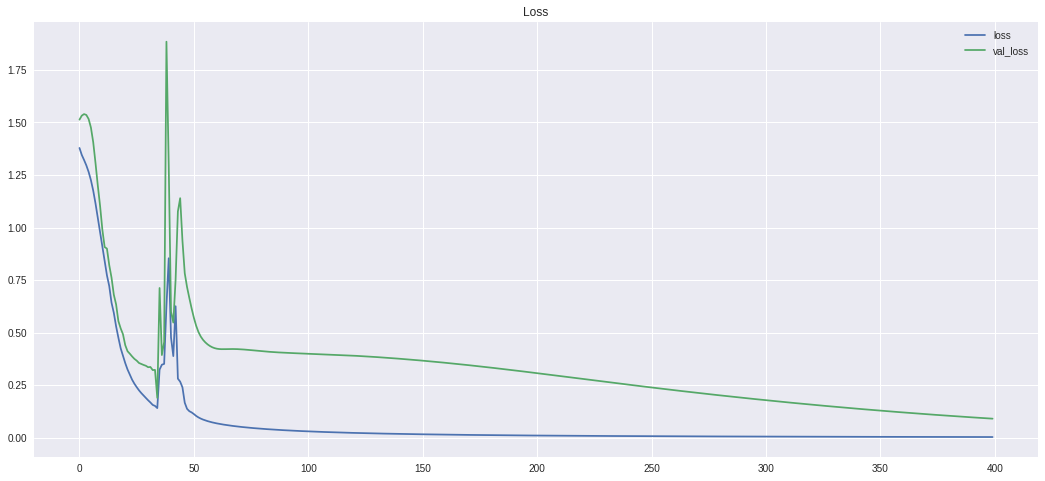

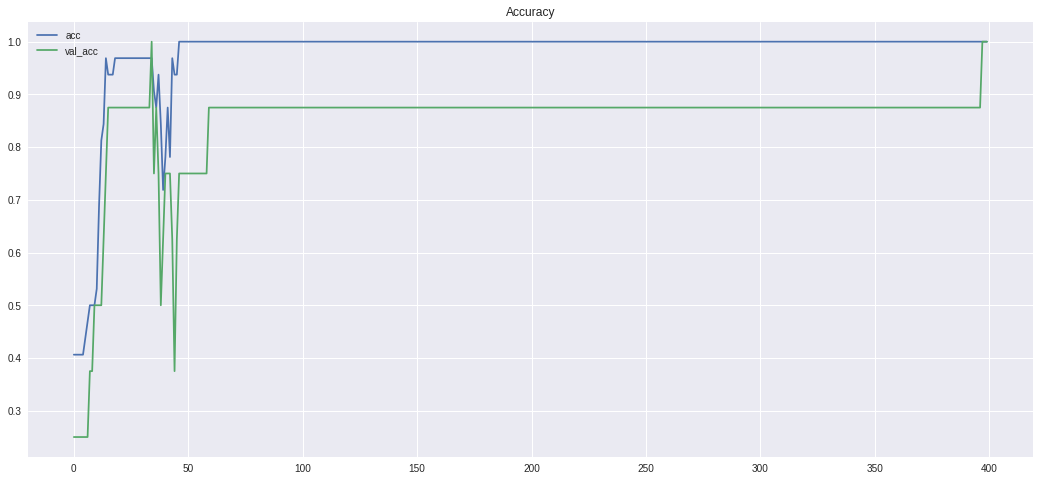

experiment 2 begins

48 secs for training


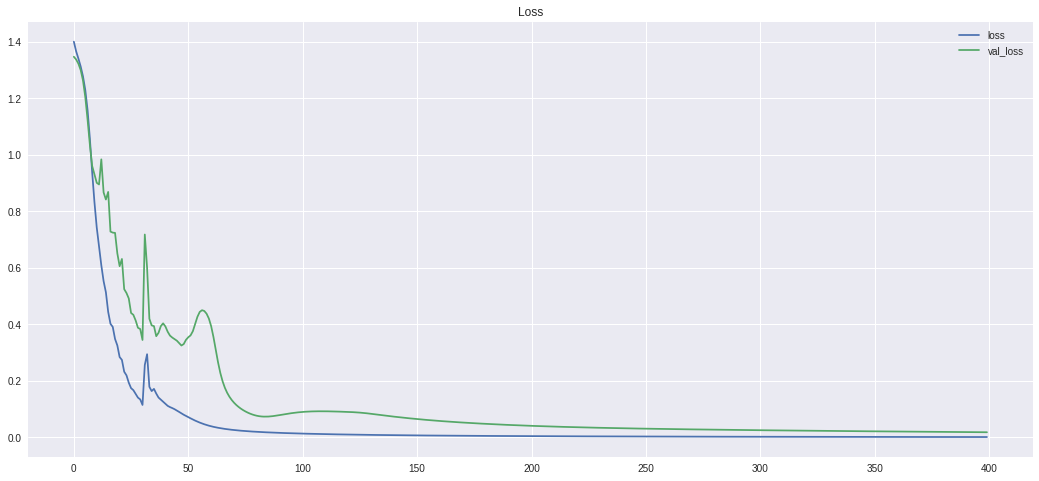

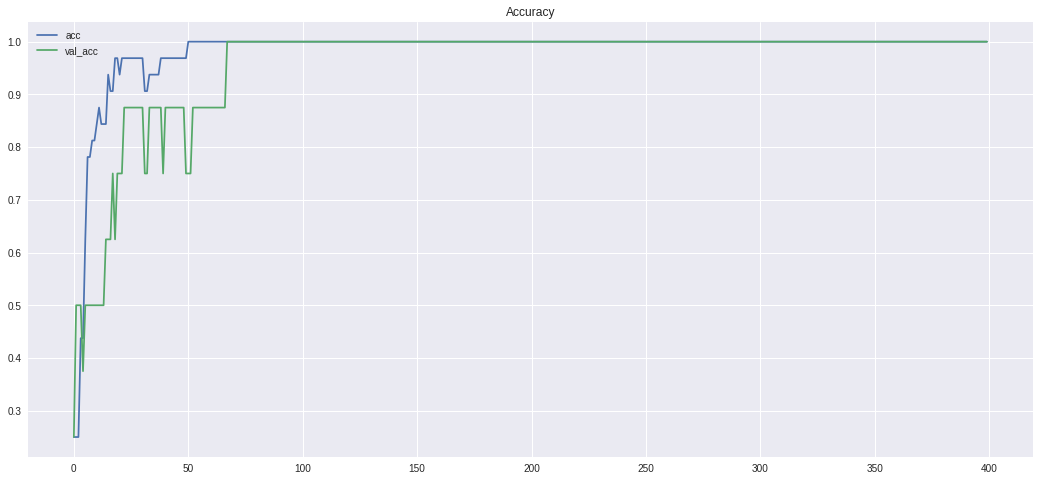

experiment 3 begins

48 secs for training


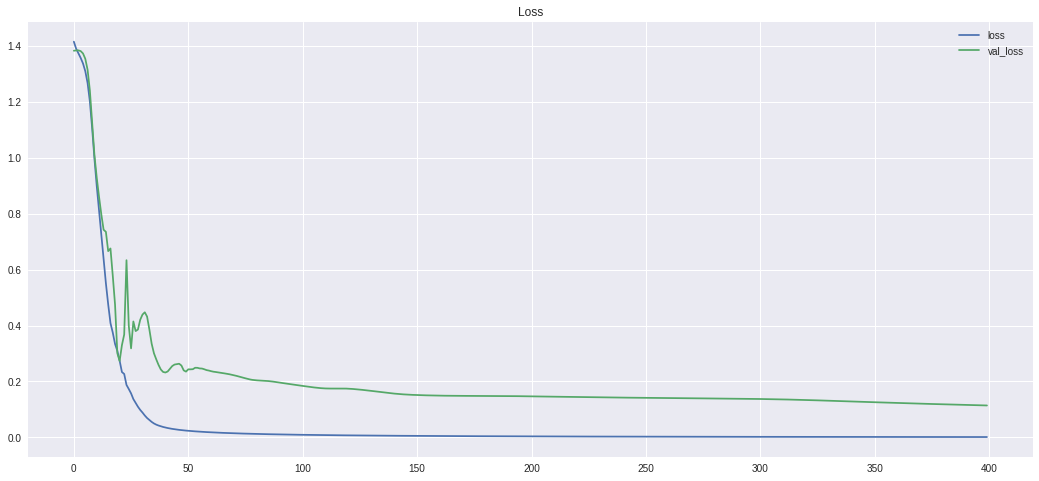

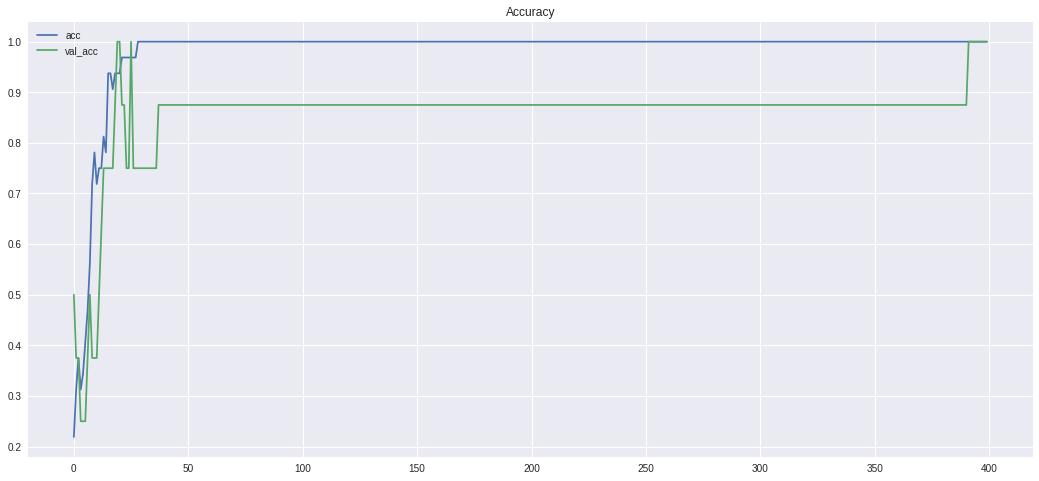

experiment 4 begins

49 secs for training


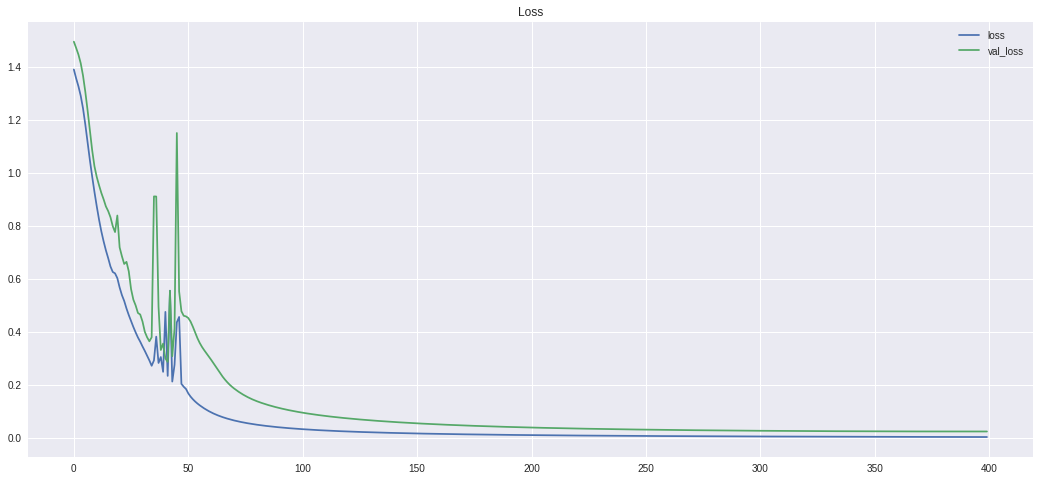

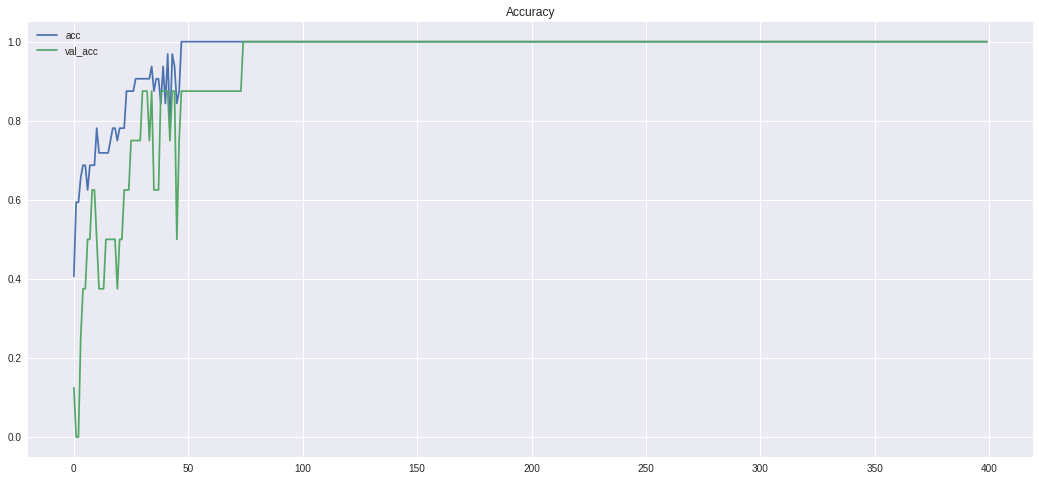

experiment 5 begins

49 secs for training


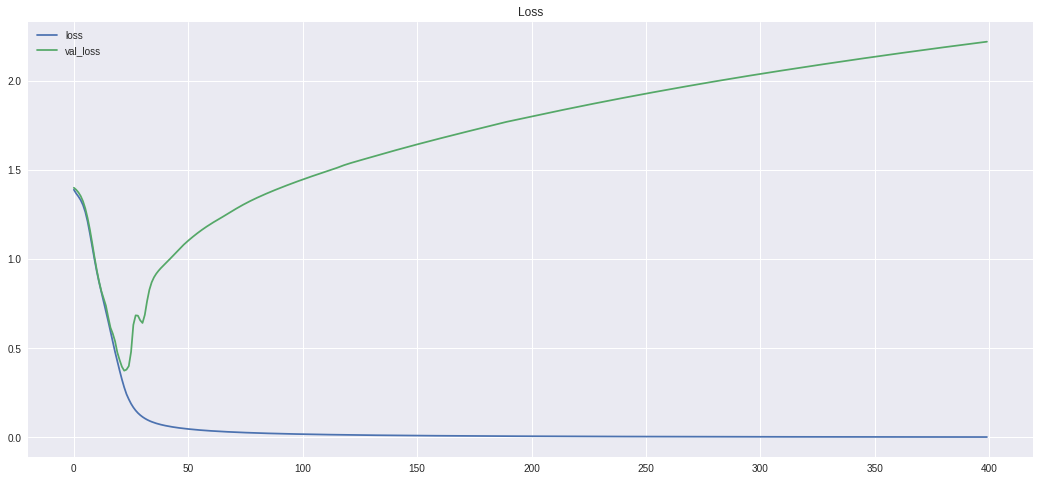

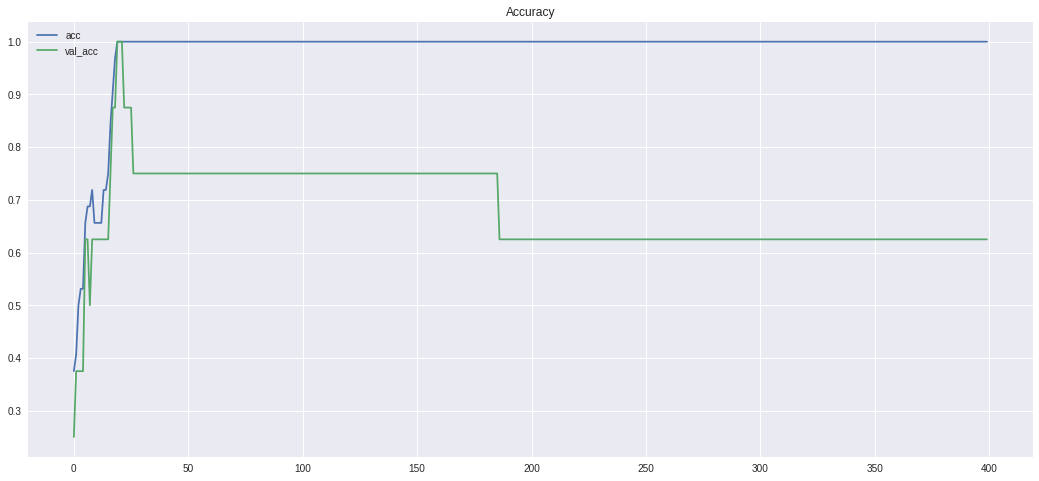

experiment 6 begins

50 secs for training


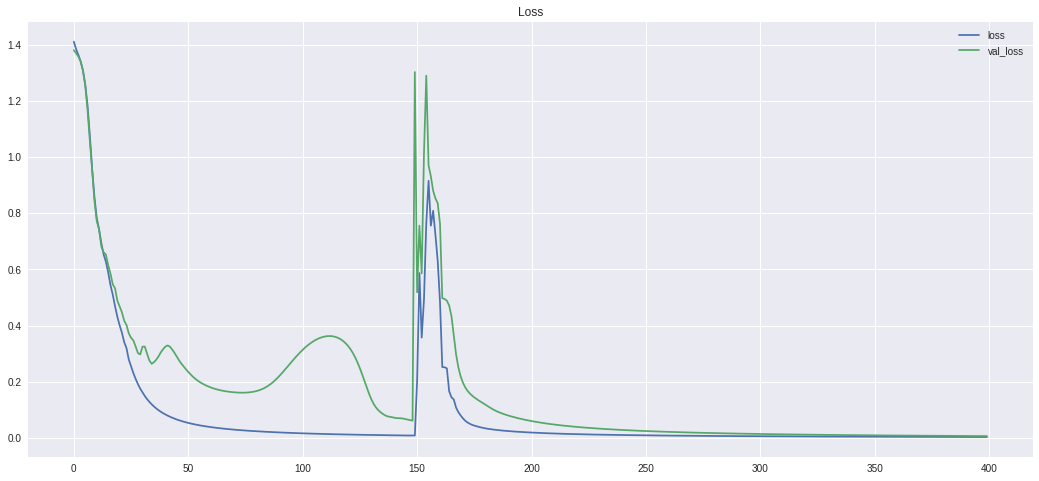

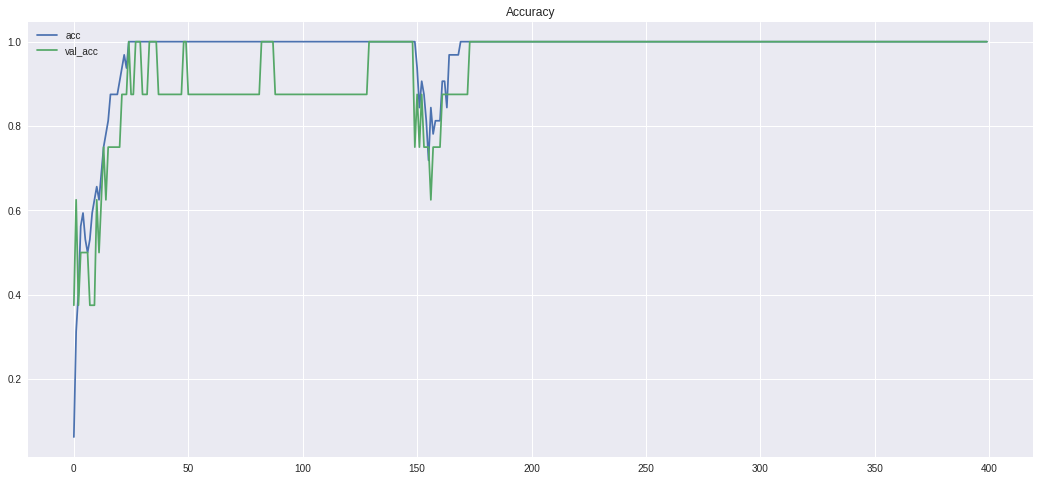

experiment 7 begins

50 secs for training


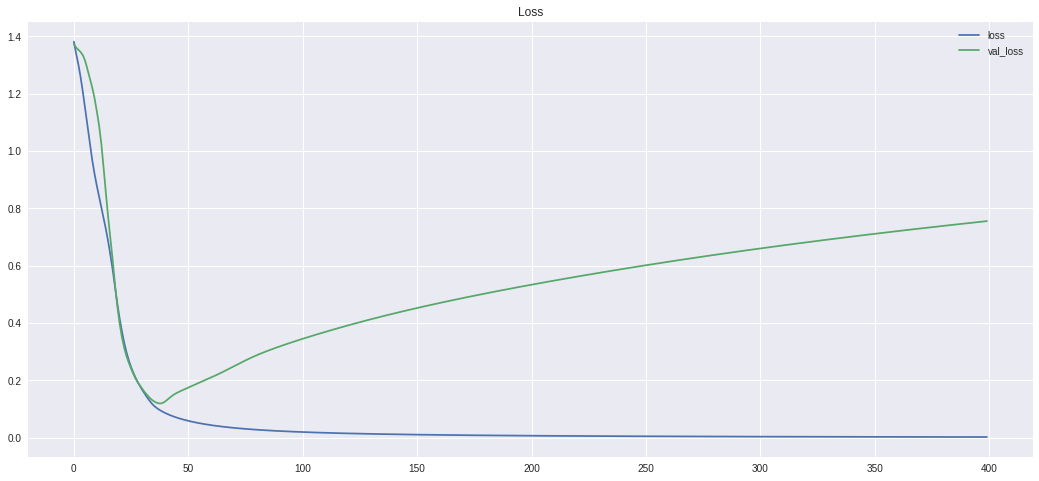

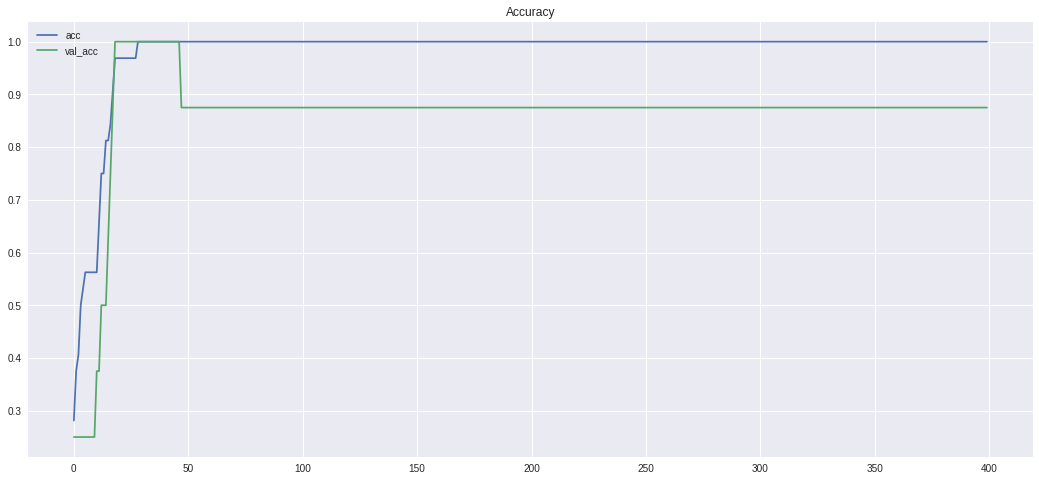

experiment 8 begins

50 secs for training


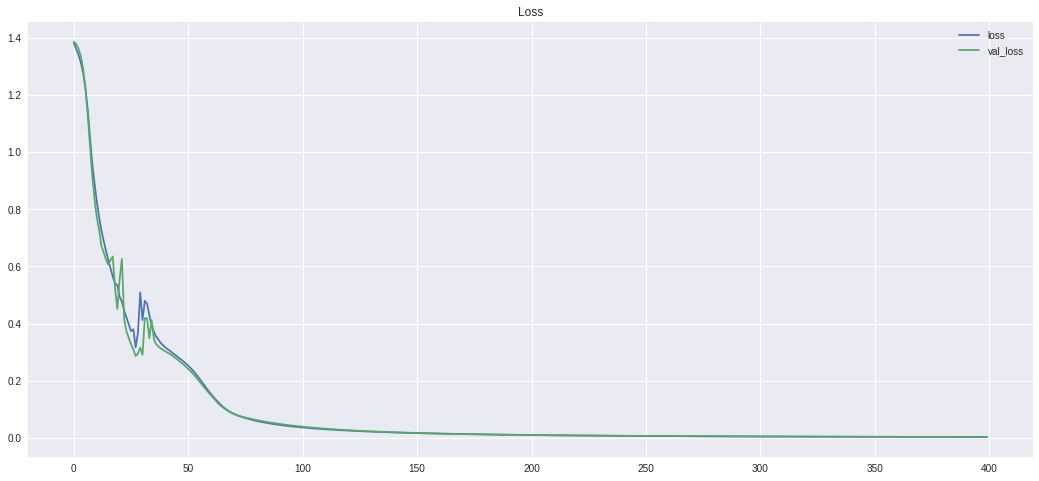

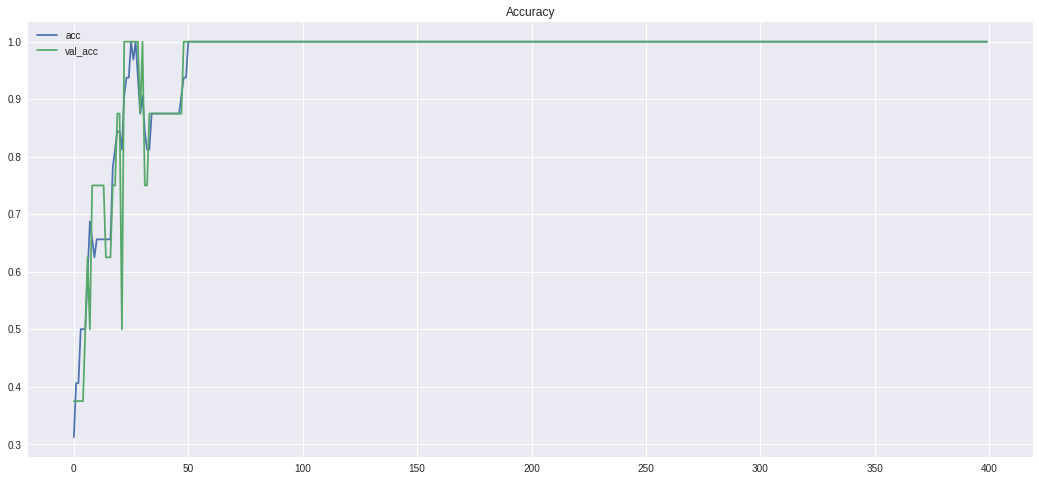

experiment 9 begins

50 secs for training


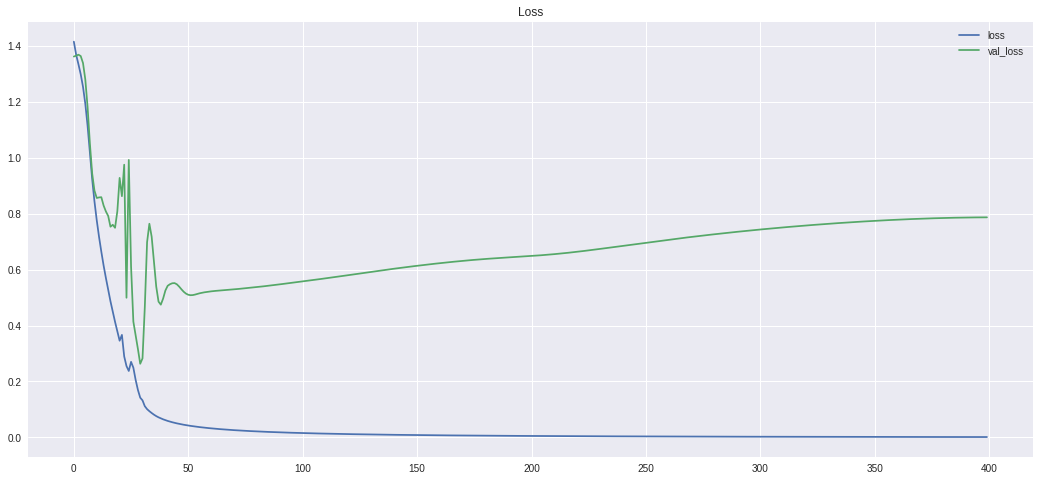

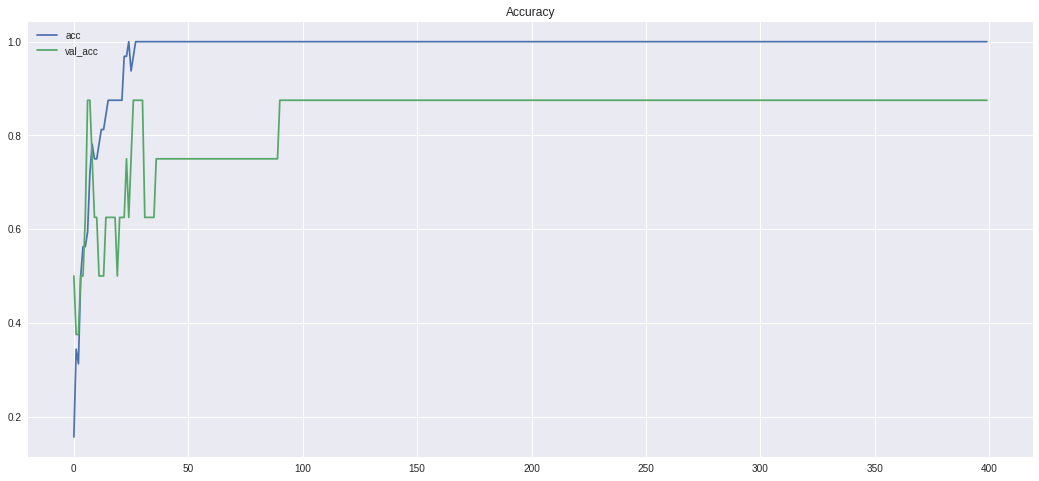

experiment 10 begins

50 secs for training


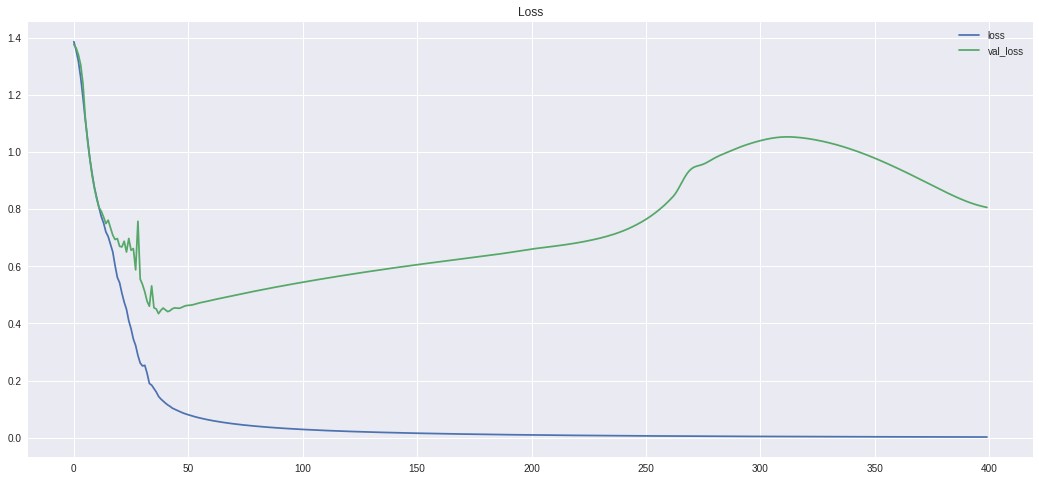

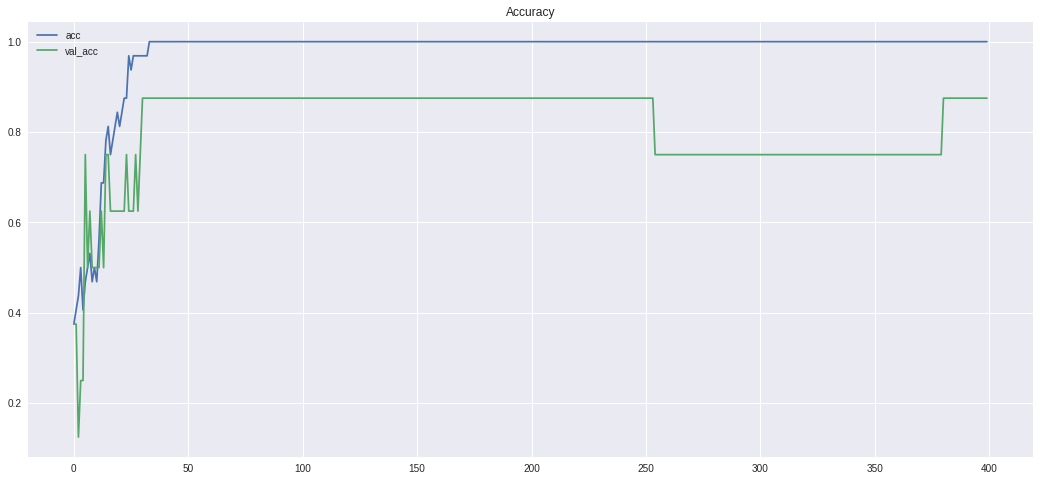

   acc_train  acc_test
0        1.0     1.000
0        1.0     1.000
0        1.0     1.000
0        1.0     1.000
0        1.0     0.625
0        1.0     1.000
0        1.0     0.875
0        1.0     1.000
0        1.0     0.875
0        1.0     0.875


In [43]:
acc = pd.DataFrame(columns=['acc_train','acc_test'])
for e in range(1,11):
  print("experiment %d begins\n"%e)
  y_train_ = np.zeros((32,303,4))
  y_train_[:,0,:] = y_train

  y_test_ = np.zeros((8,303,4))
  y_test_[:,0,:] = y_test

  shuffle_data[:32,:,:6] = x_train
  shuffle_data[:32,:,6:] = y_train_

  shuffle_data[32:,:,:6] = x_test
  shuffle_data[32:,:,6:] = y_test_


  while True:
    np.random.shuffle(shuffle_data)

    x_train = shuffle_data[:32,:,:6]
    x_test = shuffle_data[32:,:,:6]
    y_train = shuffle_data[:32,0,6:].reshape(32,4)
    y_test = shuffle_data[32:,0,6:].reshape(8,4)
    if np.sum(y_test[:,0]) == 2:
        if np.sum(y_test[:,1]) == 2:
            if np.sum(y_test[:,2]) == 2:
                if np.sum(y_test[:,3]) == 2:
                    break

  model2 = Sequential()
  model2.add(Conv1D(filters=6,kernel_size=15,strides=3,batch_input_shape=(batch_size,timesteps,data_dim)))
  model2.add(CuDNNLSTM(36, return_sequences=True))
  model2.add(CuDNNLSTM(24))
  model2.add(Dense(12,activation='tanh'))
  model2.add(Dense(4, activation='softmax'))

  model2.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

  st = time.time()
  history = model2.fit(x_train, y_train,
            batch_size=batch_size, epochs=400, shuffle=False,
            validation_data=(x_test, y_test),verbose=0)
  ft = time.time()

  print("%d secs for training"%(ft-st))

  plt.figure(figsize=(18,8))
  plt.plot(history.history['loss'],label="loss")
  plt.plot(history.history['val_loss'],label="val_loss")
  plt.title("Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(18,8))
  plt.plot(history.history['acc'],label="acc")
  plt.plot(history.history['val_acc'],label="val_acc")
  plt.title("Accuracy")
  plt.legend()
  plt.show()

  acc = acc.append(pd.DataFrame([np.array([history.history['acc'][-1],history.history['val_acc'][-1]])],columns=acc.columns))
print(acc)

#  1 Convolution layer changes input seq (303->48)

experiment:1

35 secs for training


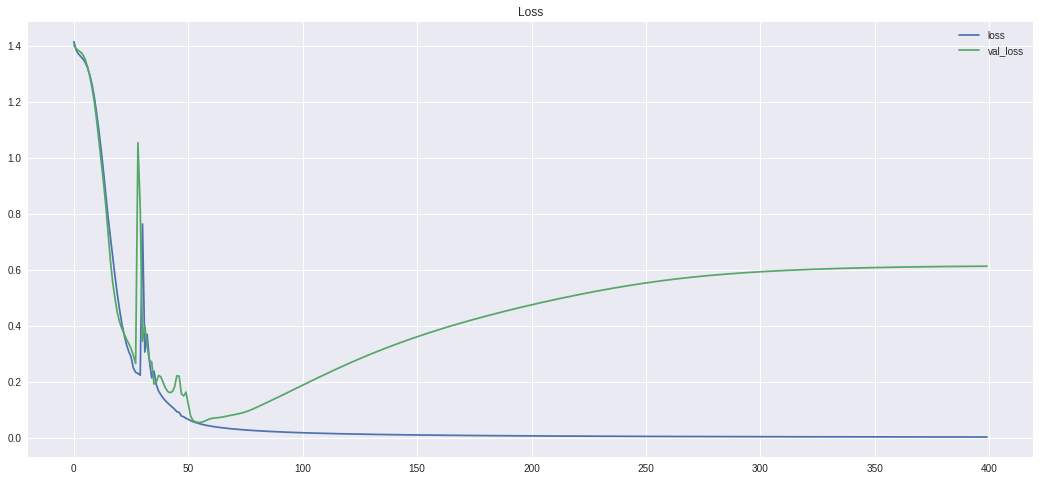

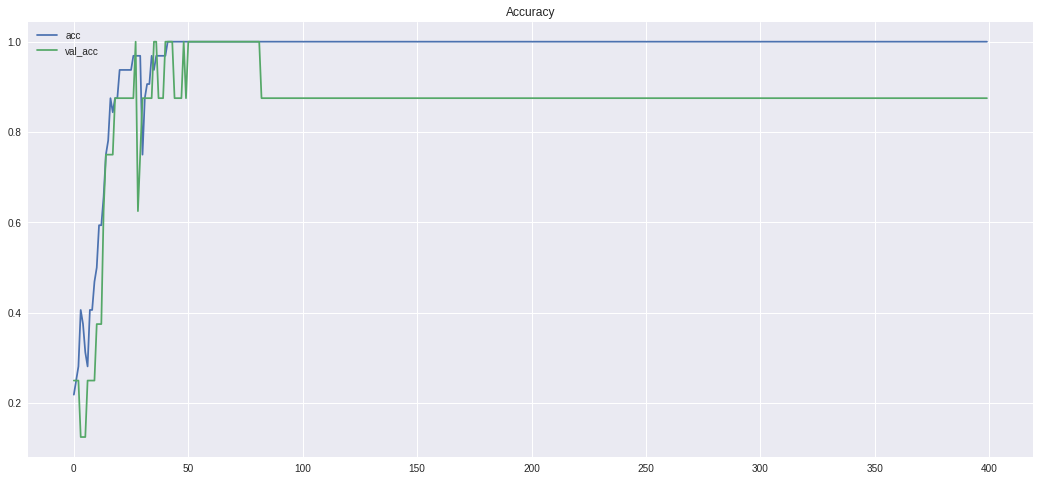

experiment:2

34 secs for training


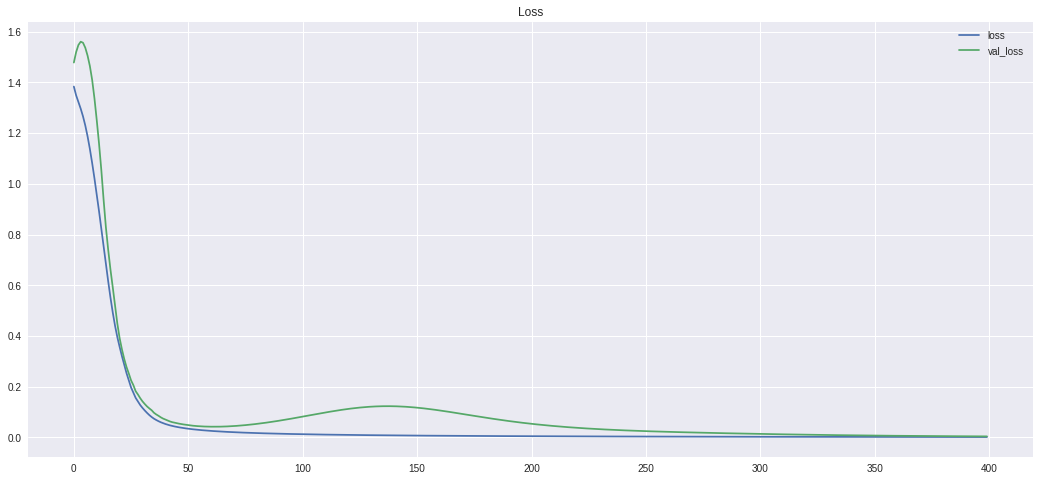

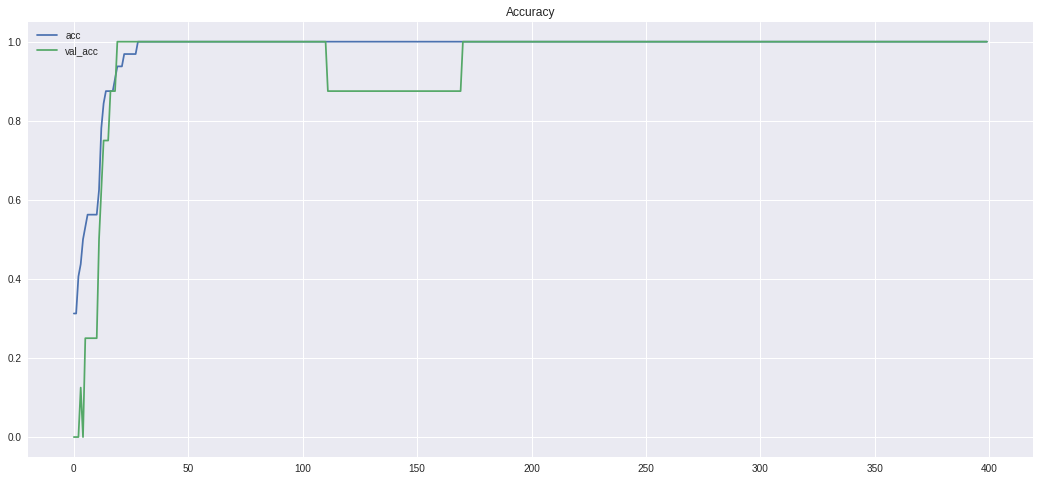

experiment:3

34 secs for training


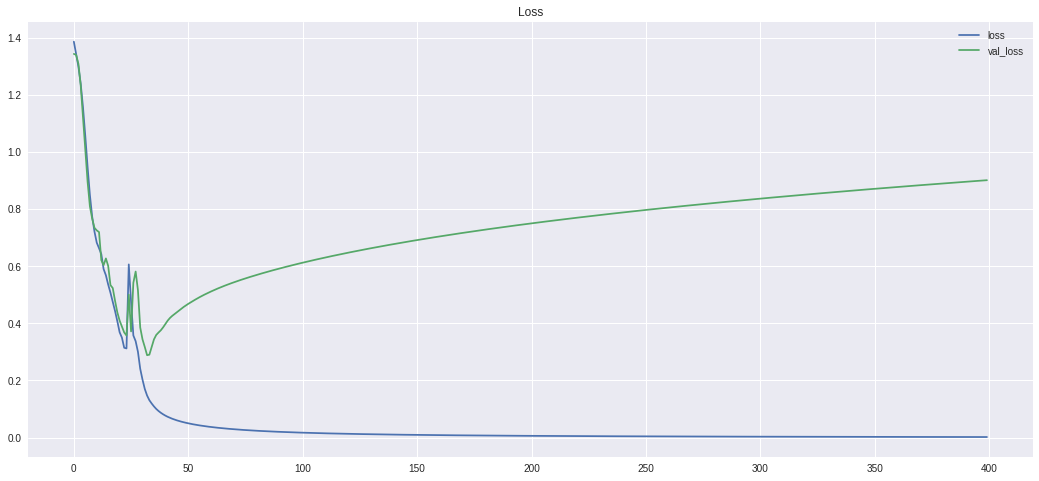

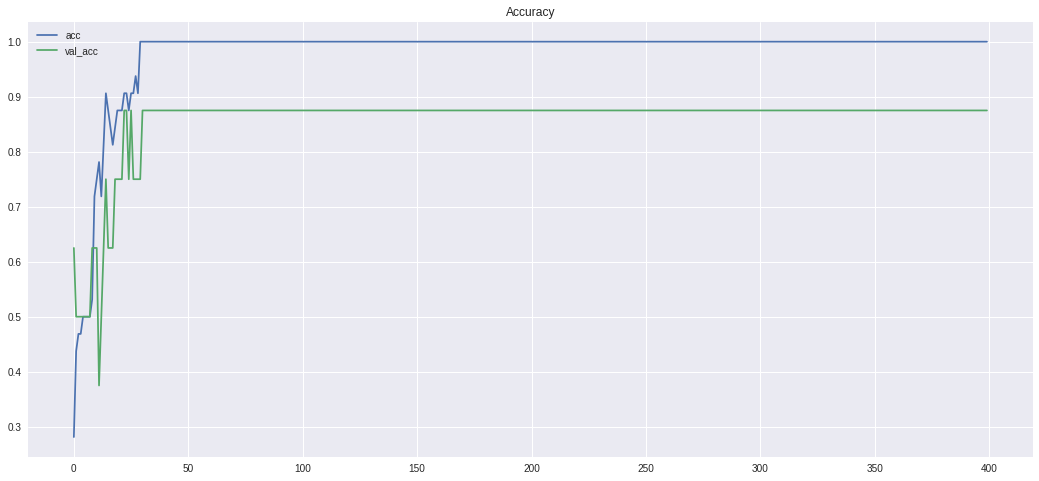

experiment:4

35 secs for training


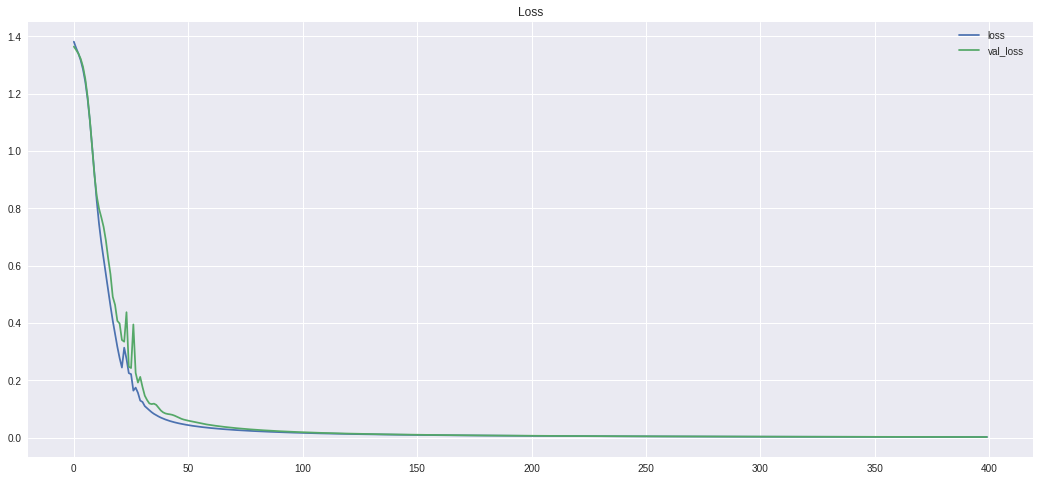

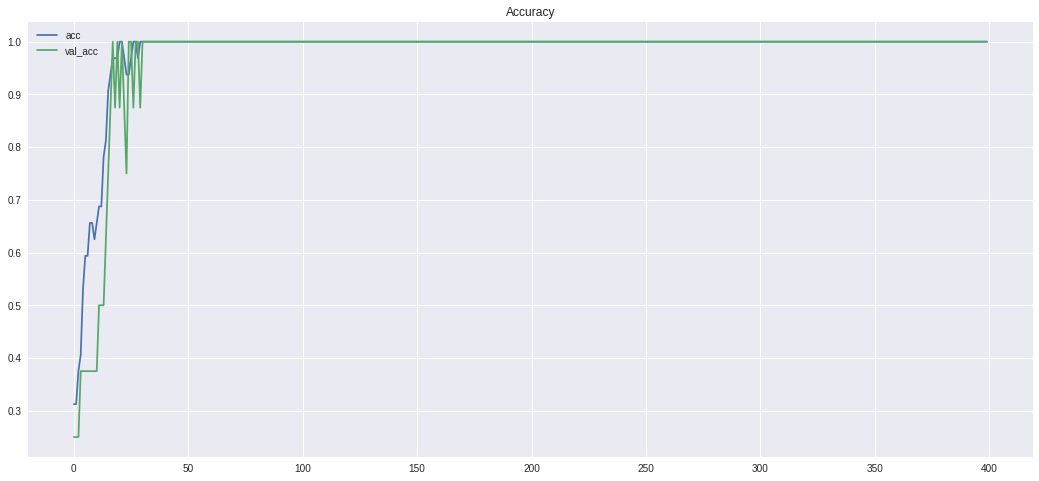

experiment:5

35 secs for training


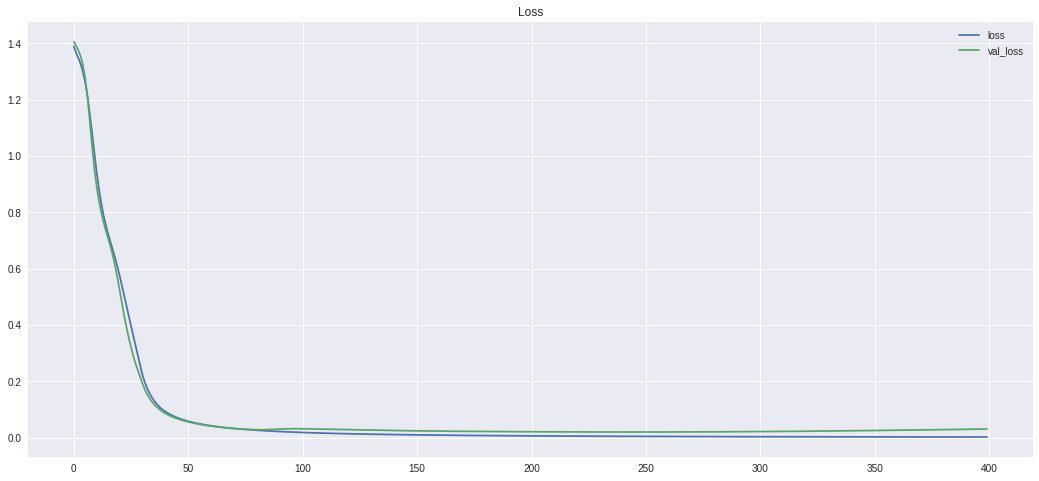

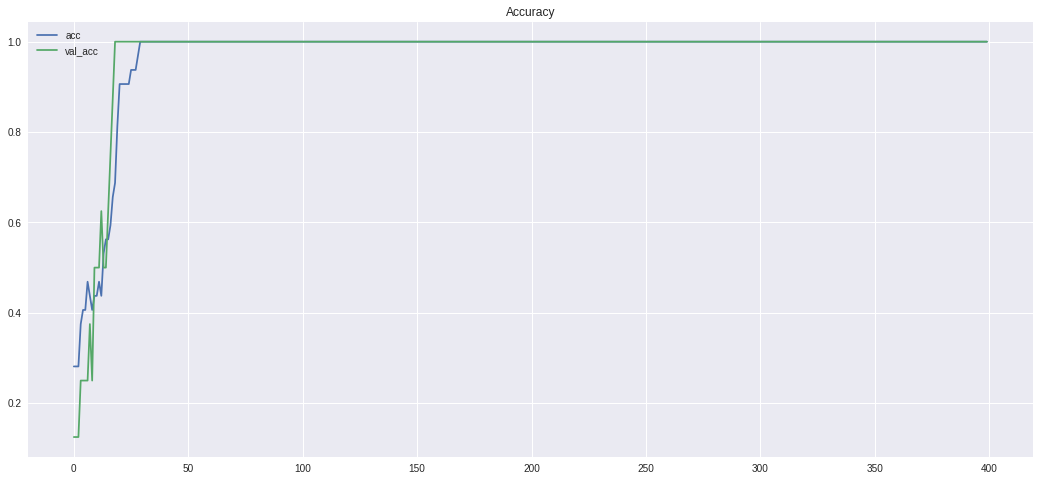

experiment:6

35 secs for training


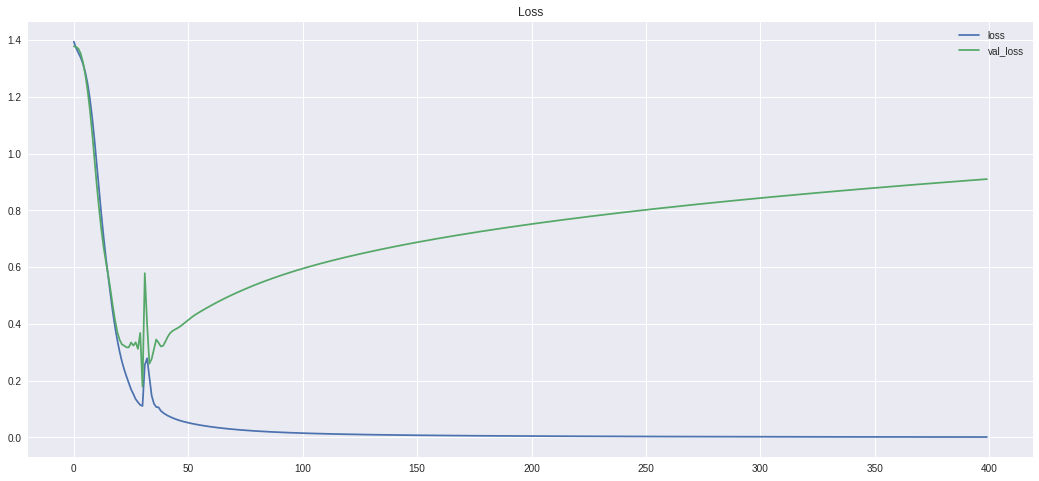

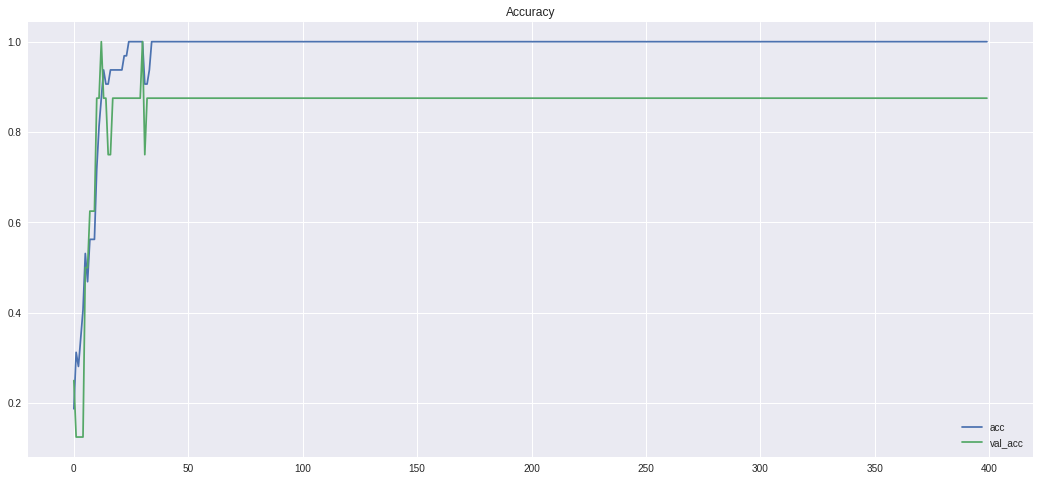

experiment:7

35 secs for training


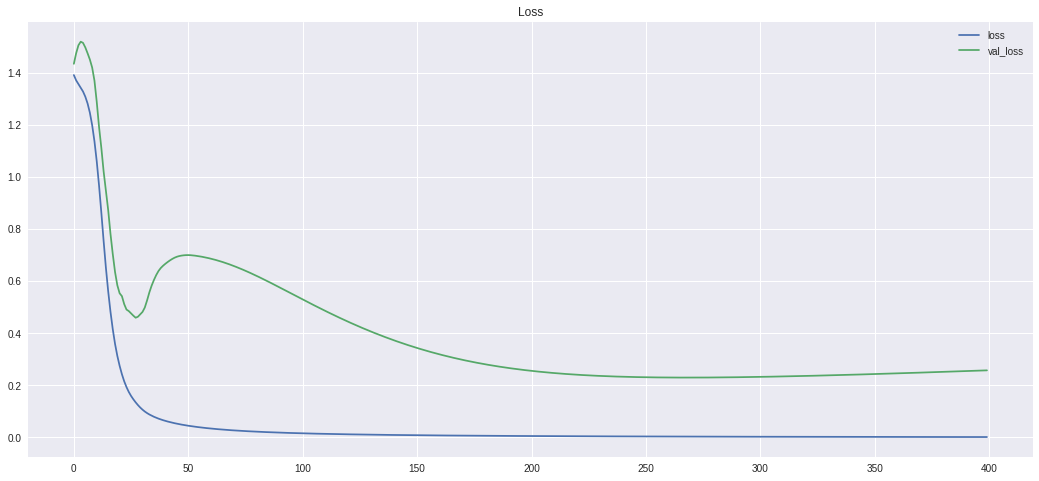

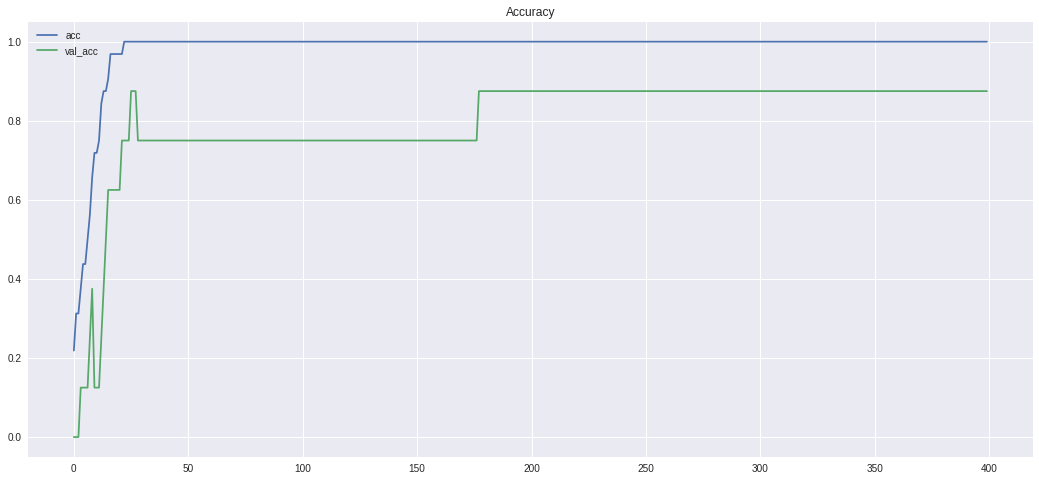

experiment:8

36 secs for training


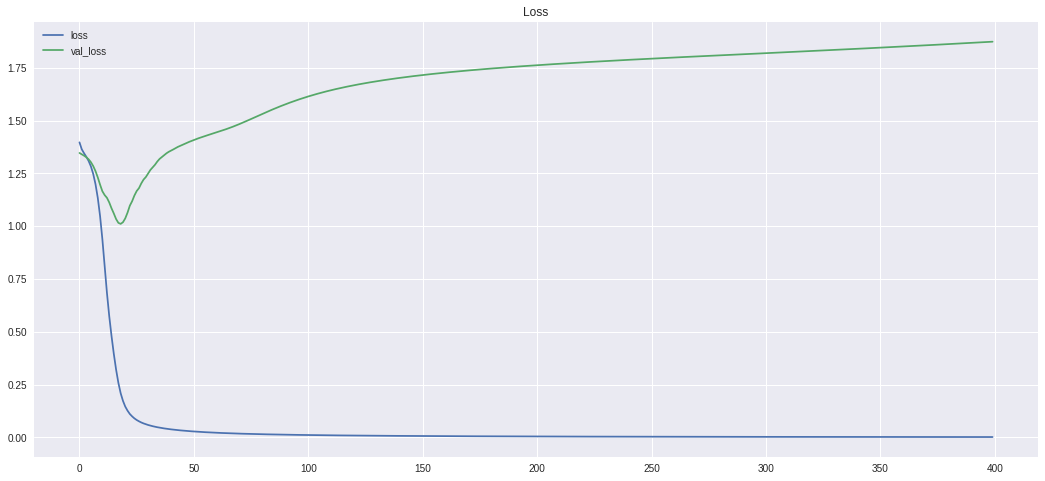

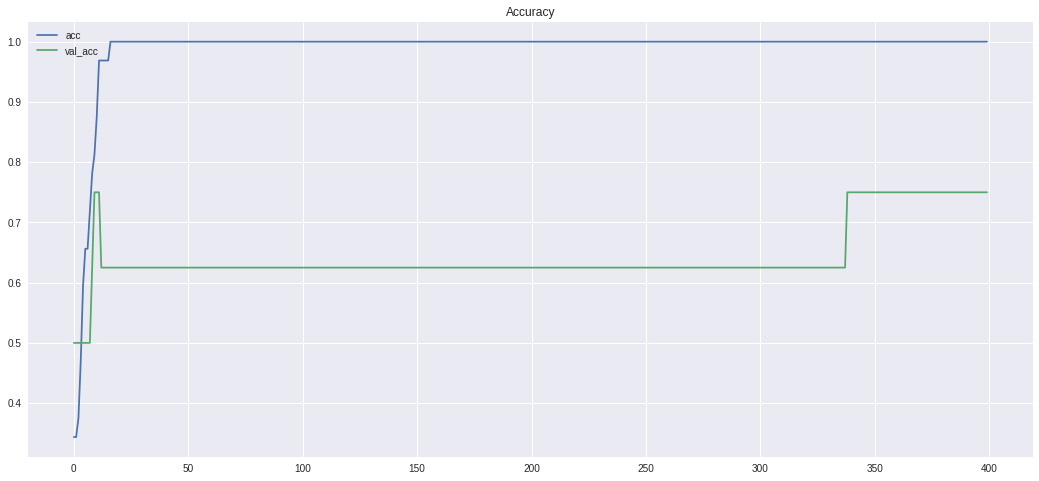

experiment:9

35 secs for training


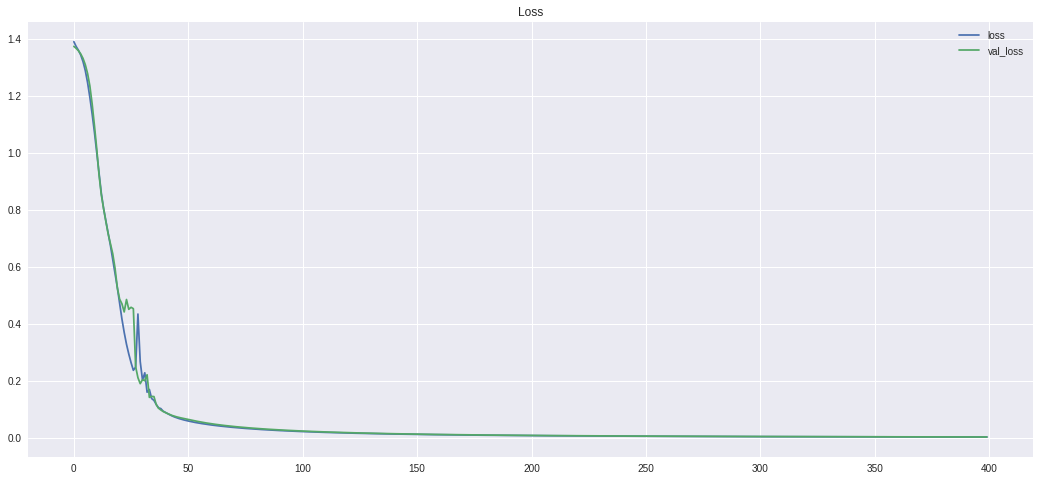

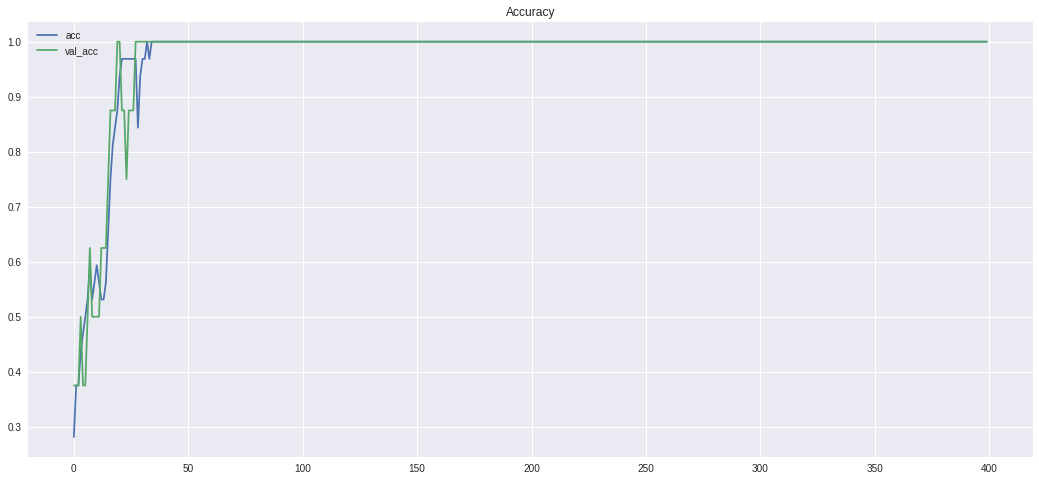

experiment:10

35 secs for training


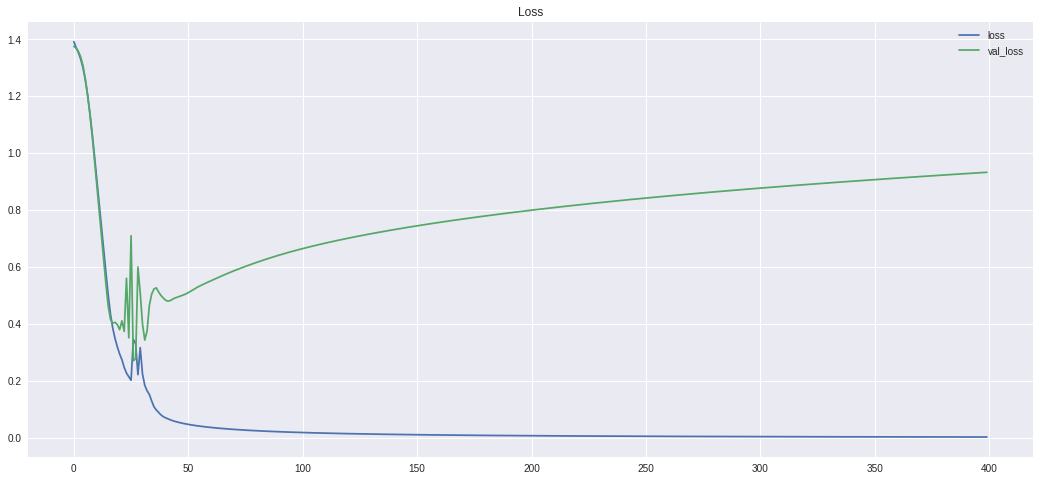

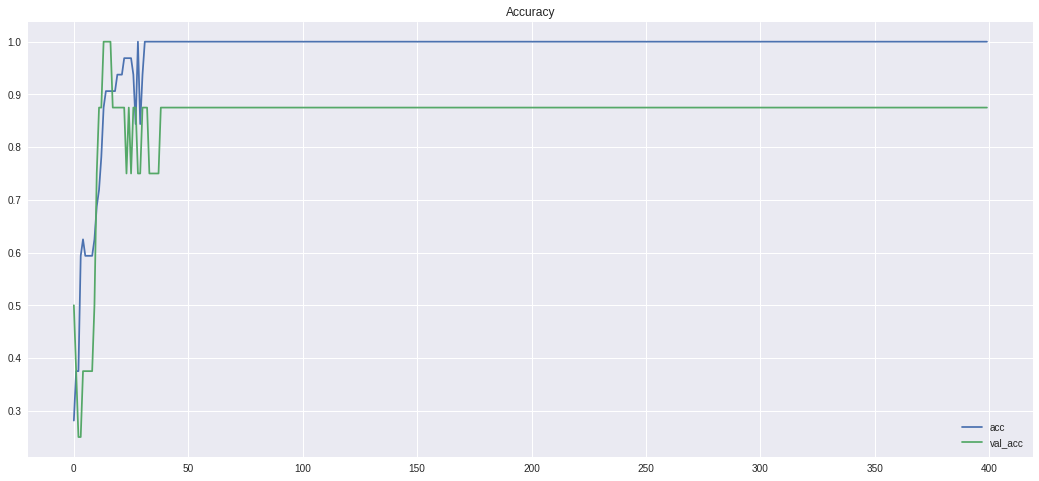

   acc_train  acc_test
0        1.0     0.875
0        1.0     1.000
0        1.0     0.875
0        1.0     1.000
0        1.0     1.000
0        1.0     0.875
0        1.0     0.875
0        1.0     0.750
0        1.0     1.000
0        1.0     0.875


In [44]:
acc = pd.DataFrame(columns=['acc_train','acc_test'])
for e in range(1,11):
  print("experiment:%d\n"%(e))

  y_train_ = np.zeros((32,303,4))
  y_train_[:,0,:] = y_train

  y_test_ = np.zeros((8,303,4))
  y_test_[:,0,:] = y_test

  shuffle_data[:32,:,:6] = x_train
  shuffle_data[:32,:,6:] = y_train_

  shuffle_data[32:,:,:6] = x_test
  shuffle_data[32:,:,6:] = y_test_


  while True:
    np.random.shuffle(shuffle_data)

    x_train = shuffle_data[:32,:,:6]
    x_test = shuffle_data[32:,:,:6]
    y_train = shuffle_data[:32,0,6:].reshape(32,4)
    y_test = shuffle_data[32:,0,6:].reshape(8,4)
    if np.sum(y_test[:,0]) == 2:
        if np.sum(y_test[:,1]) == 2:
            if np.sum(y_test[:,2]) == 2:
                if np.sum(y_test[:,3]) == 2:
                    break


  batch_size = 8
  timesteps = SEQ_LENGTH
  data_dim = 6


  model3 = Sequential()
  model3.add(Conv1D(filters=6,kernel_size=21,strides=6,batch_input_shape=(batch_size,timesteps,data_dim)))
  model3.add(CuDNNLSTM(36, return_sequences=True))
  model3.add(CuDNNLSTM(24))
  model3.add(Dense(12,activation='tanh'))
  model3.add(Dense(4, activation='softmax'))

  model3.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

  st = time.time()

  history = model3.fit(x_train, y_train,
            batch_size=batch_size, epochs=400, shuffle=False,
            validation_data=(x_test, y_test),verbose=0)
  ft = time.time()

  print("%d secs for training"%(ft-st))

  plt.figure(figsize=(18,8))
  plt.plot(history.history['loss'],label="loss")
  plt.plot(history.history['val_loss'],label="val_loss")
  plt.title("Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(18,8))
  plt.plot(history.history['acc'],label="acc")
  plt.plot(history.history['val_acc'],label="val_acc")
  plt.title("Accuracy")
  plt.legend()
  plt.show()

  acc = acc.append(pd.DataFrame([np.array([history.history['acc'][-1],history.history['val_acc'][-1]])],columns=acc.columns))
print(acc)

experiment:1

32 secs for training


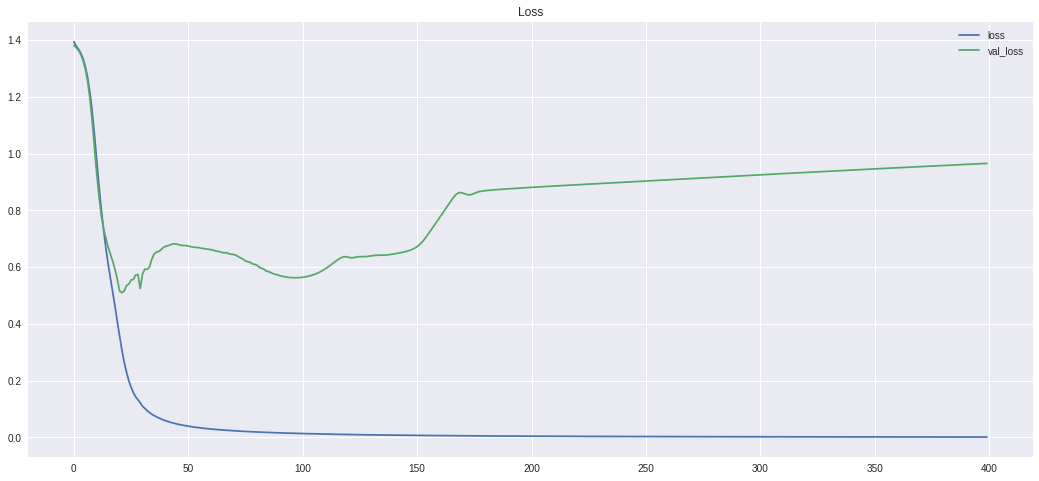

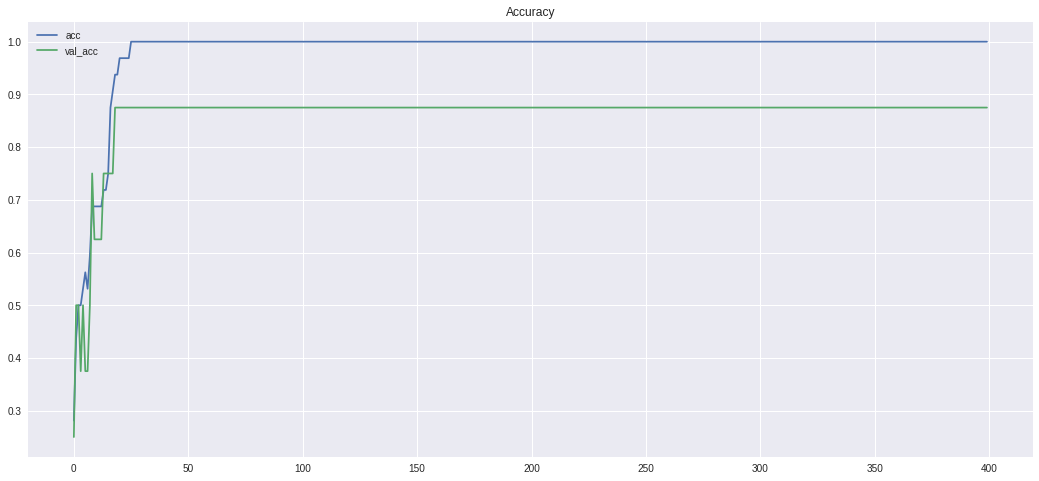

experiment:2

31 secs for training


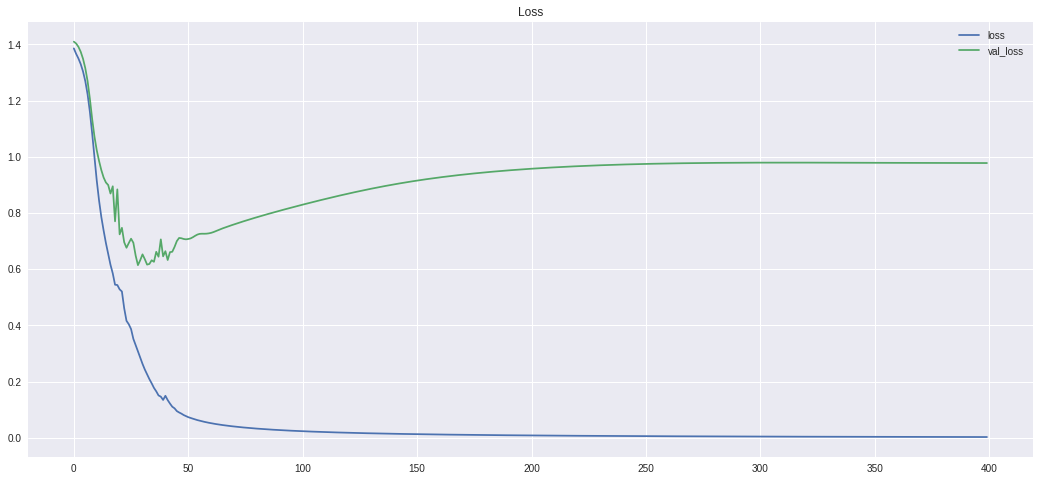

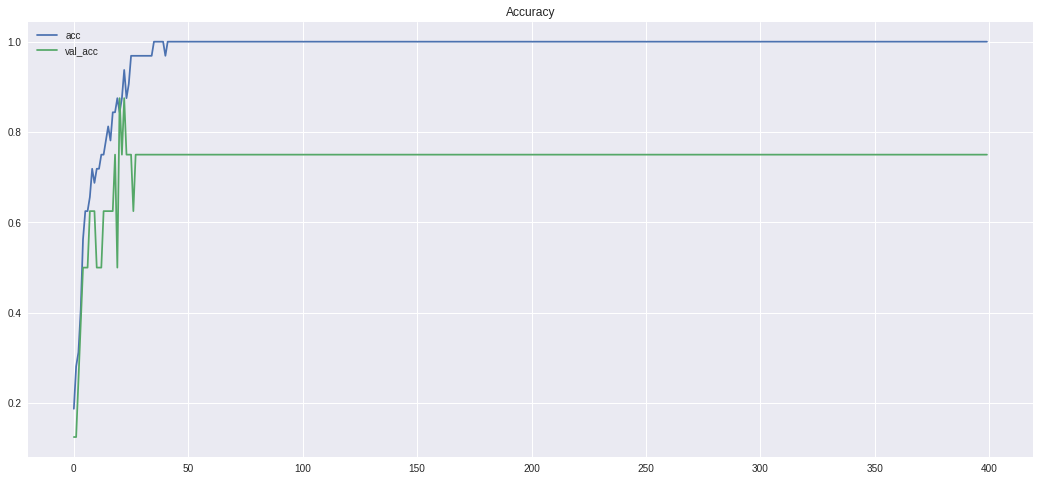

experiment:3

32 secs for training


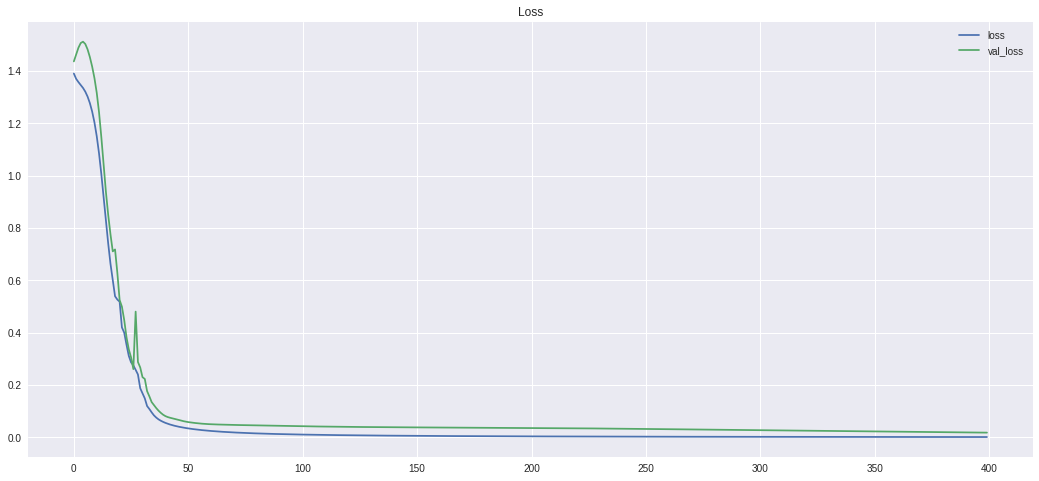

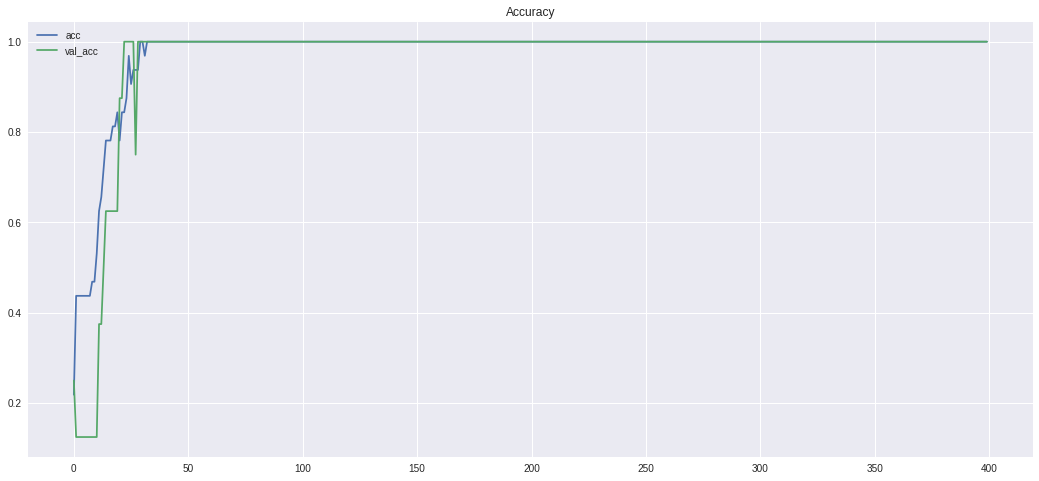

experiment:4

32 secs for training


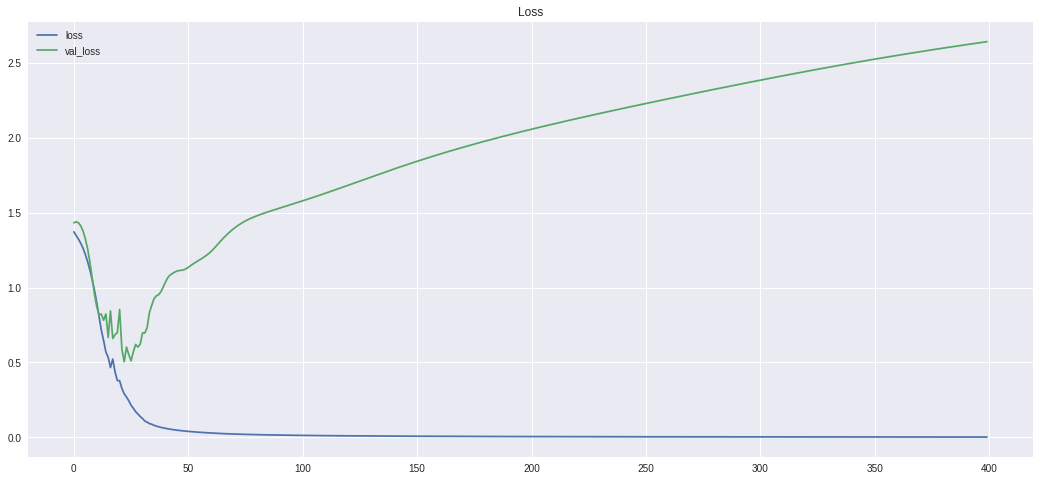

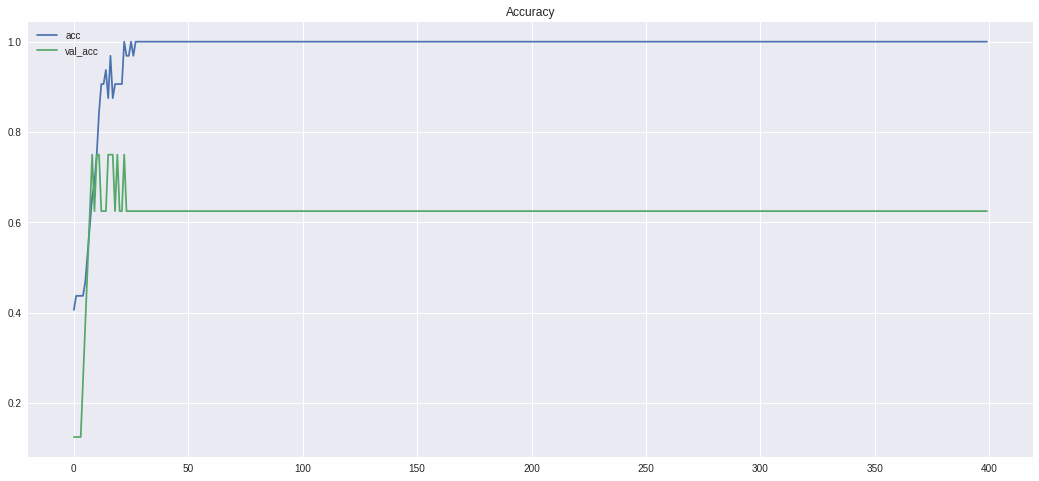

experiment:5

32 secs for training


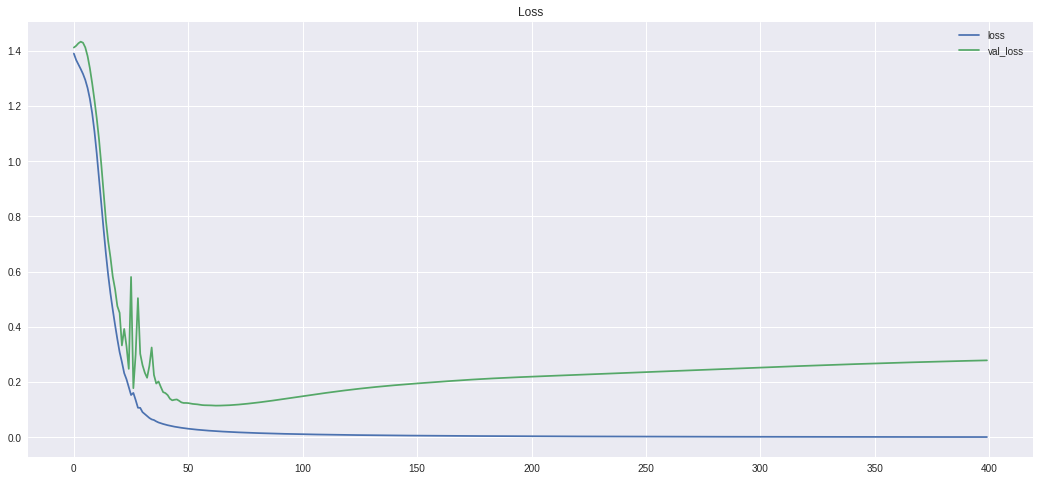

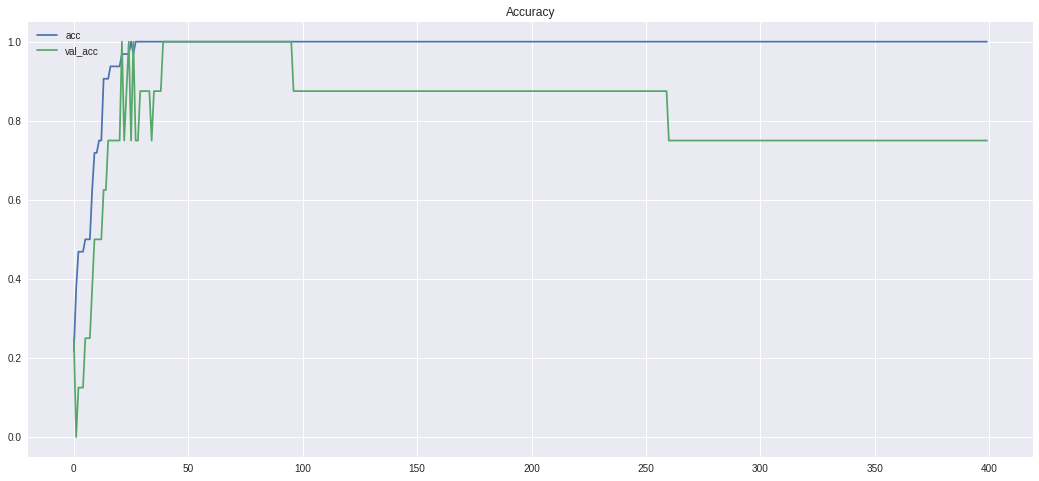

experiment:6

32 secs for training


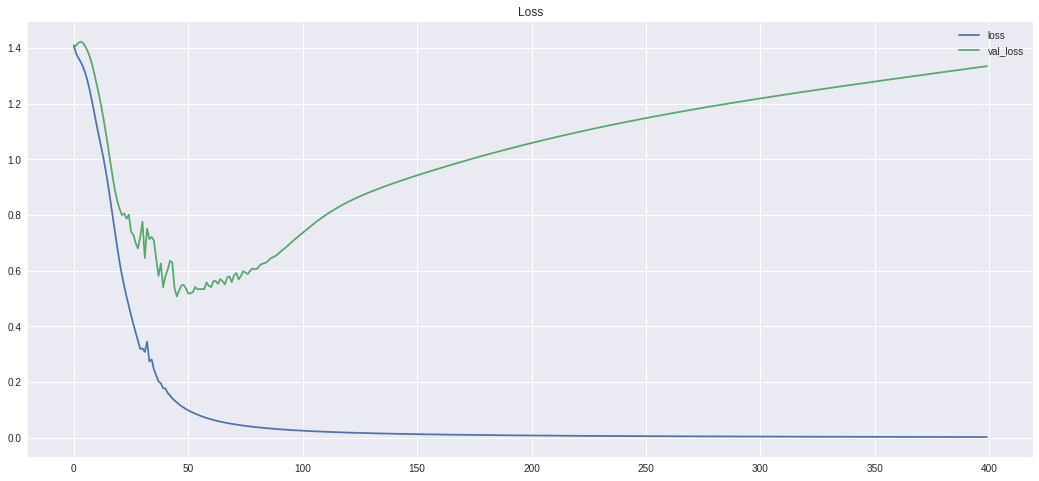

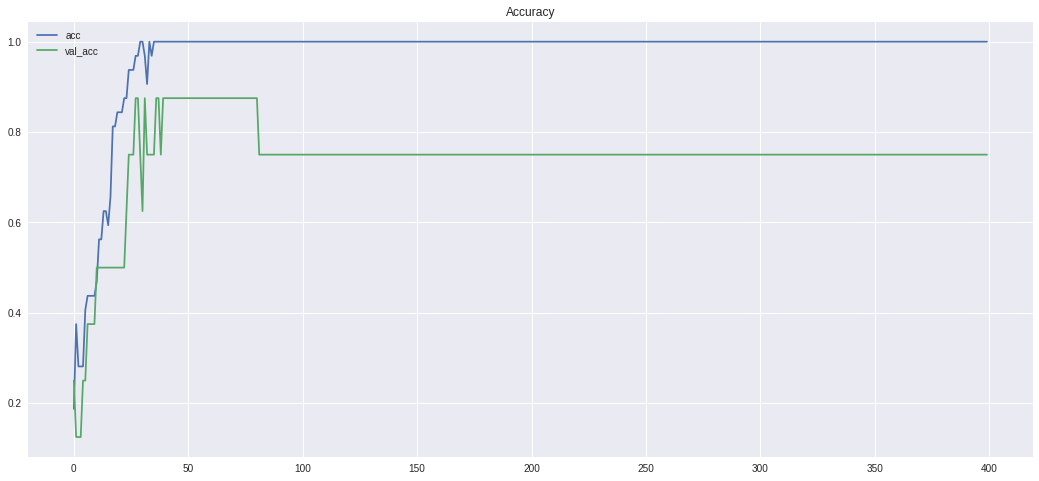

experiment:7

32 secs for training


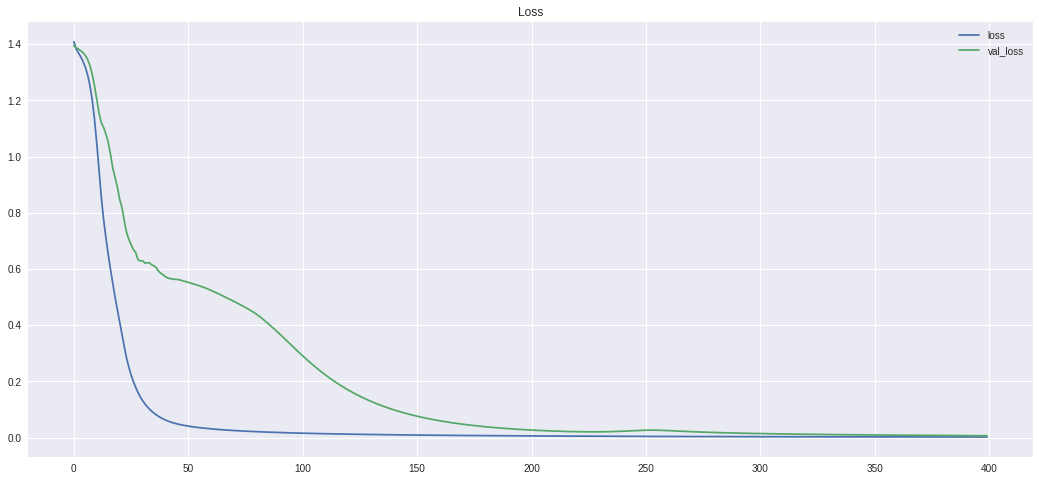

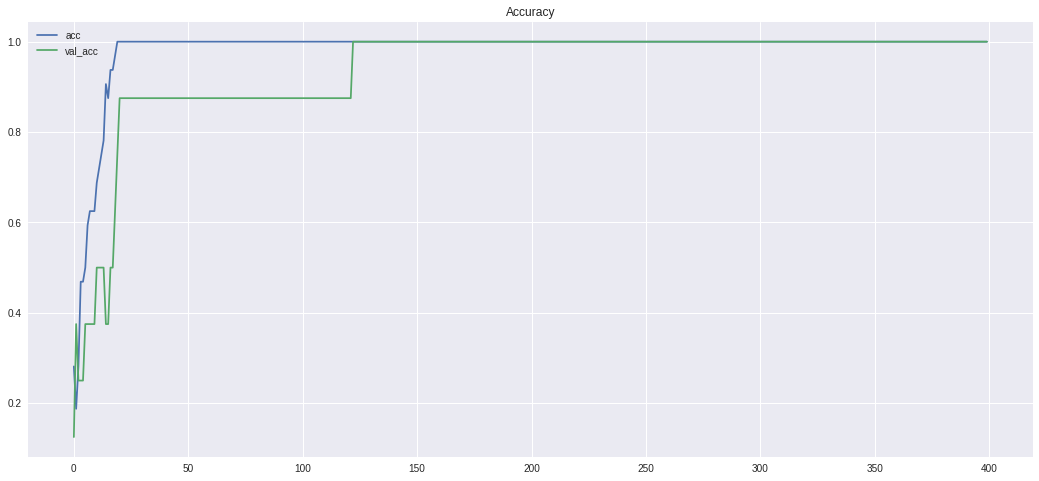

experiment:8

32 secs for training


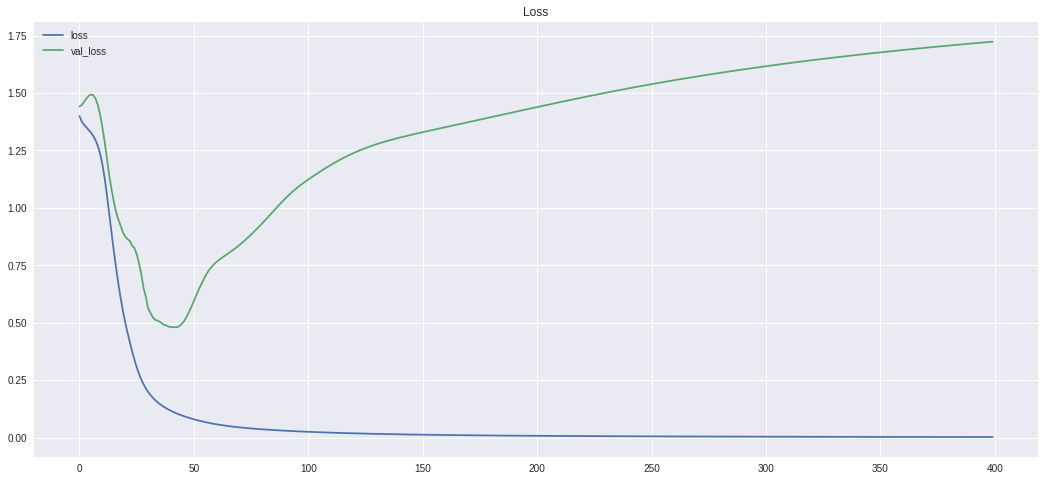

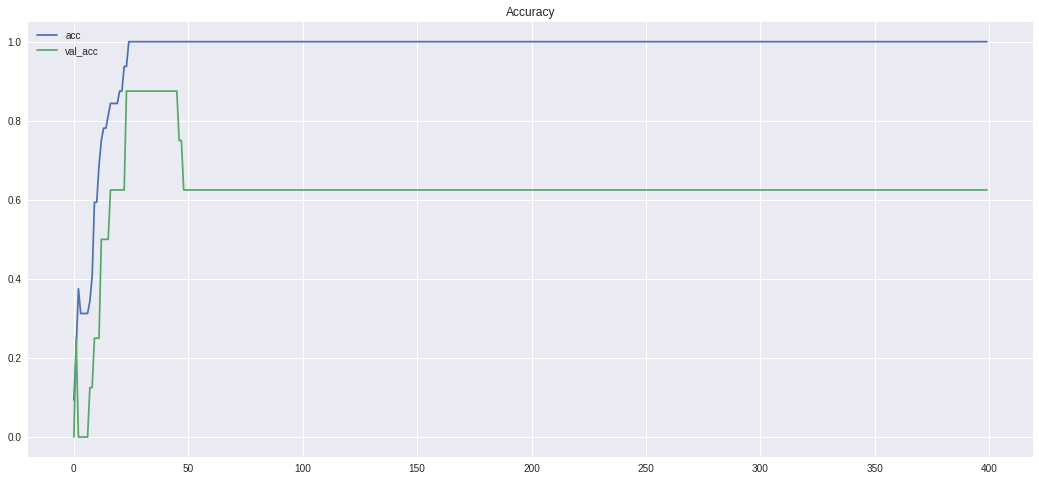

experiment:9

33 secs for training


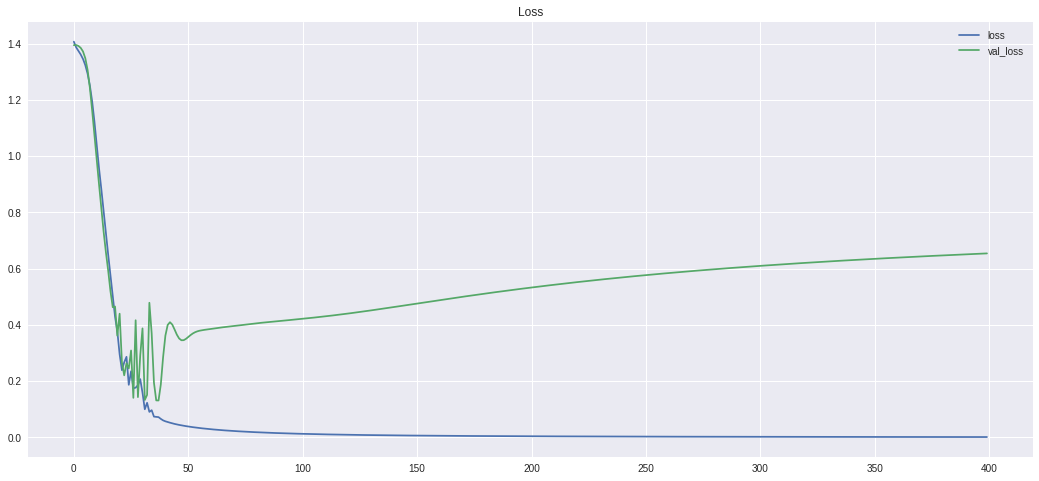

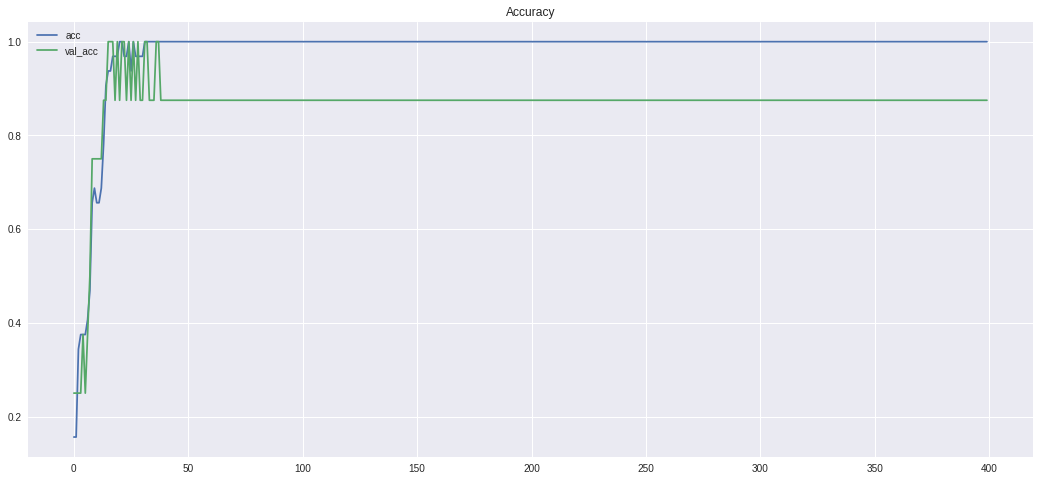

experiment:10

33 secs for training


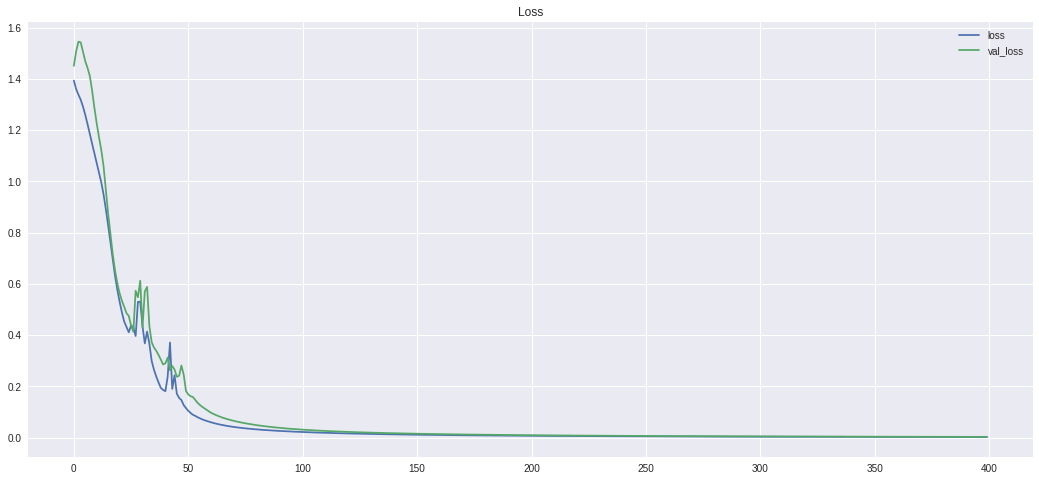

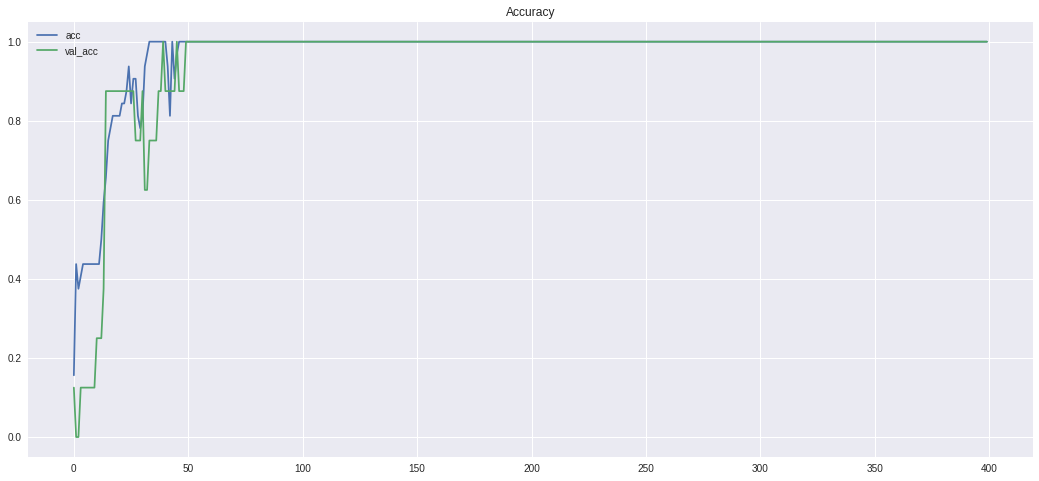

   acc_train  acc_test
0        1.0     0.875
0        1.0     0.750
0        1.0     1.000
0        1.0     0.625
0        1.0     0.750
0        1.0     0.750
0        1.0     1.000
0        1.0     0.625
0        1.0     0.875
0        1.0     1.000


In [50]:
acc = pd.DataFrame(columns=['acc_train','acc_test'])
for e in range(1,11):
  print("experiment:%d\n"%(e))

  y_train_ = np.zeros((32,303,4))
  y_train_[:,0,:] = y_train

  y_test_ = np.zeros((8,303,4))
  y_test_[:,0,:] = y_test

  shuffle_data[:32,:,:6] = x_train
  shuffle_data[:32,:,6:] = y_train_

  shuffle_data[32:,:,:6] = x_test
  shuffle_data[32:,:,6:] = y_test_


  while True:
    np.random.shuffle(shuffle_data)

    x_train = shuffle_data[:32,:,:6]
    x_test = shuffle_data[32:,:,:6]
    y_train = shuffle_data[:32,0,6:].reshape(32,4)
    y_test = shuffle_data[32:,0,6:].reshape(8,4)
    if np.sum(y_test[:,0]) == 2:
        if np.sum(y_test[:,1]) == 2:
            if np.sum(y_test[:,2]) == 2:
                if np.sum(y_test[:,3]) == 2:
                    break


  batch_size = 8
  timesteps = SEQ_LENGTH
  data_dim = 6


  model4 = Sequential()
  model4.add(Conv1D(filters=6,kernel_size=30,strides=8,batch_input_shape=(batch_size,timesteps,data_dim)))
  model4.add(CuDNNLSTM(36, return_sequences=True))
  model4.add(CuDNNLSTM(24))
  model4.add(Dense(12,activation='tanh'))
  model4.add(Dense(4, activation='softmax'))

  model4.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])

  st = time.time()

  history = model4.fit(x_train, y_train,
            batch_size=batch_size, epochs=400, shuffle=False,
            validation_data=(x_test, y_test),verbose=0)
  ft = time.time()

  print("%d secs for training"%(ft-st))

  plt.figure(figsize=(18,8))
  plt.plot(history.history['loss'],label="loss")
  plt.plot(history.history['val_loss'],label="val_loss")
  plt.title("Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(18,8))
  plt.plot(history.history['acc'],label="acc")
  plt.plot(history.history['val_acc'],label="val_acc")
  plt.title("Accuracy")
  plt.legend()
  plt.show()

  acc = acc.append(pd.DataFrame([np.array([history.history['acc'][-1],history.history['val_acc'][-1]])],columns=acc.columns))
print(acc)